# PETS for all samples

In [1]:
import gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn
from sklearn.metrics import mean_squared_error, r2_score

import pickle

import os



In [2]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class EnsembleModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers, num_nodes, activation, num_ensembles):
        super(EnsembleModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.num_nodes = num_nodes
        self.activation = activation
        self.num_ensembles = num_ensembles

        self.ensemble_models = nn.ModuleList()
        for _ in range(num_ensembles):
            model = self._build_model()
            self.ensemble_models.append(model)

    def _build_model(self):
        layers = []
        layers.append(nn.Linear(self.input_size, self.num_nodes))
        layers.append(self.activation)

        for _ in range(self.num_layers - 1):
            layers.append(nn.Linear(self.num_nodes, self.num_nodes))
            layers.append(self.activation)

        layers.append(nn.Linear(self.num_nodes, self.output_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        means = []
        stds = []
        for model in self.ensemble_models:
            output = model(x)
            mean = output[:, :self.output_size // 2]
            std = torch.exp(output[:, self.output_size // 2:])
            means.append(mean)
            stds.append(std)
        means = torch.stack(means, dim=0)
        stds = torch.stack(stds, dim=0)
        final_mean = torch.mean(means, dim=0)
        final_std = torch.mean(stds, dim=0)
        return final_mean, final_std
    
# Loss function
def gaussian_likelihood(mean_pred, std_pred, target):
    EPS = 1e-6 
    std_pred = torch.clamp(std_pred, min=EPS) 
    
    # Negative log likelihood of Gaussian distribution
    loss = torch.mean(0.5 * ((target - mean_pred) / std_pred) ** 2 + torch.log(std_pred) + 0.5 * np.log(2 * np.pi))
    
    if torch.isnan(loss):
#         print('target: ',target,' mean: ', mean_pred, ' std: ',std_pred)
        print('mean: ', mean_pred, ' std: ',std_pred)
    return loss

EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=5, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=12, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: 0.7755473051888059
Epoch [1/50], Test Loss: 0.49467144362510196
Epoch [2/50], Training Loss: 0.6869627578087537
Epoch [2/50], Test Loss: 0.4724639256795247
Epoch [3/50], Training Loss: 0.6272279936597642
Epoch [3/50], Test Loss: 0.7511301939449613
Epoch [4/50], Training Loss: 0.618954455947496
Epoch [4/50], Test Loss: 0.6530605204521663
Epoch [5/50], Training Loss: 0.4477724565334054
Epoch [5/50], Test Loss: 0.32851652588163105
Epoch [6/50], Training Loss: 0.4157772129512878
Epoch [6/50], Test Loss: 0.28884531060854596
Epoch [7/50], Training Loss: 0.7473

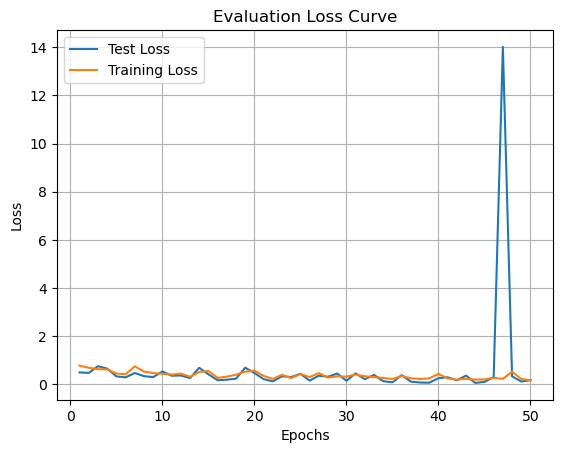

Mean Squared Error (MSE): 0.8027523159980774
R-squared: 0.04724649003808643
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=5, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=12, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: 0.7306542297204336
Epoch [1/50], Test Loss: 0.6994266966505657
Epoch [2/50], Training Loss: 0.5020535441929709
Epoch [2/50], Test Loss: 0.42896046335735016
Epoch [3/50], Training Loss: 0.49317930061779097
Epoch [3/50], Test Loss: 0.4085901442264754
Epoch [4/50], Training Loss: 0.4190514191665395
Epoch [4/50], Test Loss: 0.2618108219984505
Epoch [5/50], Training Loss: 0.5373911375895342
Epoch [5/50], Test Loss: 0.6256860681469478
Epoch [6/50], Training Loss: 0.4430814702138156
Epo

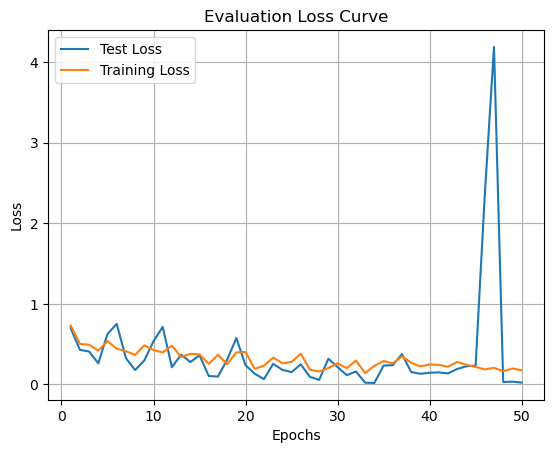

Mean Squared Error (MSE): 0.8461880087852478
R-squared: -0.0027328197350015015
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=5, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=12, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: 0.6314144176189179
Epoch [1/50], Test Loss: 0.44962325929961305
Epoch [2/50], Training Loss: 0.5696963067854768
Epoch [2/50], Test Loss: 0.41237947614269055
Epoch [3/50], Training Loss: 0.5048294191393807
Epoch [3/50], Test Loss: 0.2793293097551833
Epoch [4/50], Training Loss: 0.4560848985427864
Epoch [4/50], Test Loss: 0.2271492479250152
Epoch [5/50], Training Loss: 0.3721770342866011
Epoch [5/50], Test Loss: 0.2032925686699913
Epoch [6/50], Training Loss: 0.3594809528080605


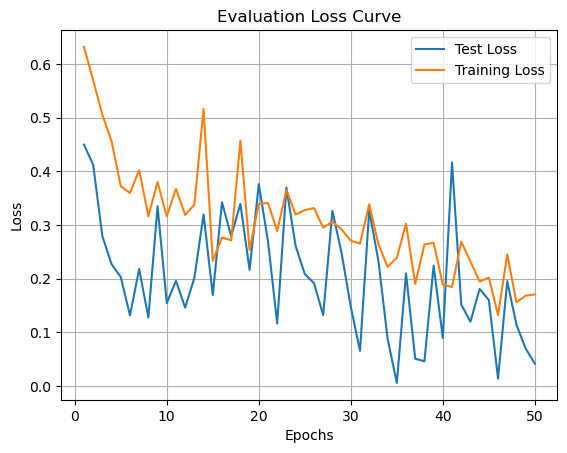

Mean Squared Error (MSE): 0.8442651629447937
R-squared: -0.0014213584684835319
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=5, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=12, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: 0.6870011560447685
Epoch [1/50], Test Loss: 0.3277257213079597
Epoch [2/50], Training Loss: 0.4647250305098313
Epoch [2/50], Test Loss: 0.3568644216692305
Epoch [3/50], Training Loss: 0.4352549458579435
Epoch [3/50], Test Loss: 0.39028868055438615
Epoch [4/50], Training Loss: 0.3889756892500985
Epoch [4/50], Test Loss: 0.23492956565195822
Epoch [5/50], Training Loss: 0.4232422480889183
Epoch [5/50], Test Loss: 0.16573549116928263
Epoch [6/50], Training Loss: 0.4577830971768042

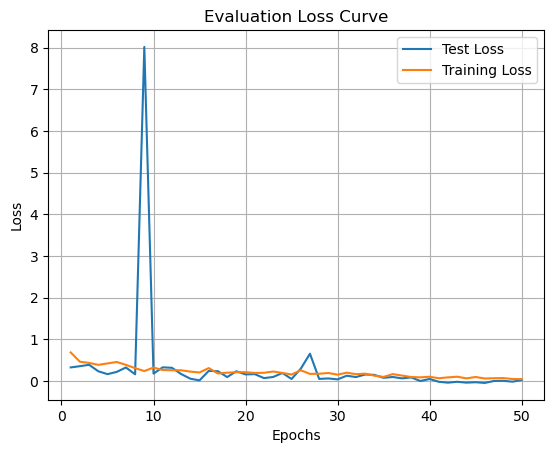

Mean Squared Error (MSE): 0.8444288372993469
R-squared: -0.0021177772276614513
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=5, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=12, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: 0.5870990283745561
Epoch [1/50], Test Loss: 0.49231638000034295
Epoch [2/50], Training Loss: 0.4405964151297292
Epoch [2/50], Test Loss: 0.3214915138178359
Epoch [3/50], Training Loss: 0.3539252863969091
Epoch [3/50], Test Loss: 0.6124402007546288
Epoch [4/50], Training Loss: 0.34739837376586946
Epoch [4/50], Test Loss: 0.12922781141186224
Epoch [5/50], Training Loss: 0.33789606021976265
Epoch [5/50], Test Loss: 0.23323994350081054
Epoch [6/50], Training Loss: 0.26486537207199

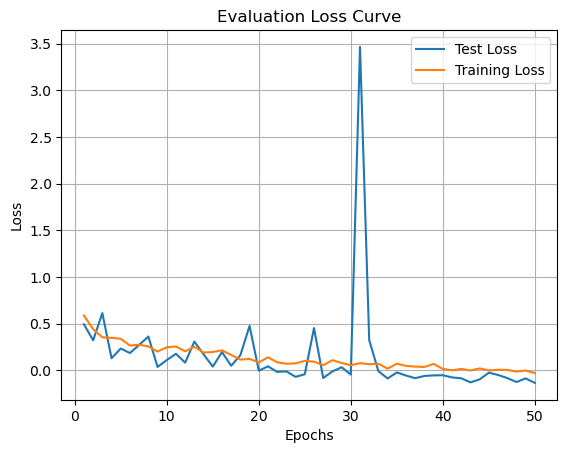

Mean Squared Error (MSE): 0.7728176116943359
R-squared: 0.054220665292863644
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=3, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=8, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: -0.11203987124562263
Epoch [1/50], Test Loss: -0.7884395907795618
Epoch [2/50], Training Loss: -0.43355969166755676
Epoch [2/50], Test Loss: -0.11589547908968395
Epoch [3/50], Training Loss: -0.6232583721280098
Epoch [3/50], Test Loss: -0.772887008530753
Epoch [4/50], Training Loss: -1.0416985332965851
Epoch [4/50], Test Loss: -1.027893140202477
Epoch [5/50], Training Loss: -1.1126190111339092
Epoch [5/50], Test Loss: -1.2331567539109125
Epoch [6/50], Training Loss: -0.7999368858

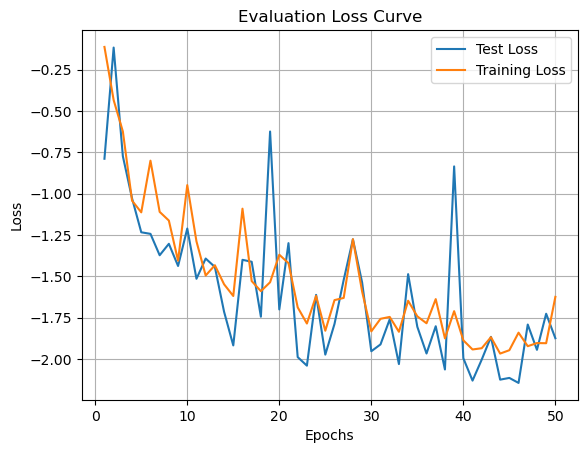

Mean Squared Error (MSE): 0.5106301307678223
R-squared: 0.24923828222855457
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=3, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=8, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: -0.15715219617635012
Epoch [1/50], Test Loss: -0.5478349554538727
Epoch [2/50], Training Loss: -0.8338492922931909
Epoch [2/50], Test Loss: -1.1661899662017823
Epoch [3/50], Training Loss: -1.2682878752201796
Epoch [3/50], Test Loss: -1.4672947540283203
Epoch [4/50], Training Loss: -1.2830690906792879
Epoch [4/50], Test Loss: -1.7340744771957397
Epoch [5/50], Training Loss: -1.322101699858904
Epoch [5/50], Test Loss: -1.3725370063781739
Epoch [6/50], Training Loss: -1.245113548278

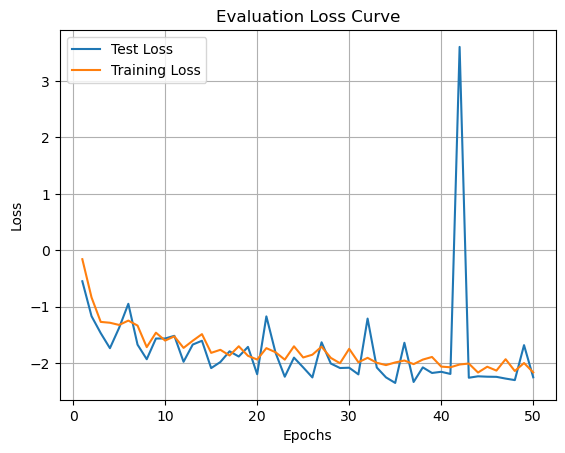

Mean Squared Error (MSE): 0.4939879775047302
R-squared: 0.24957003063768346
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=3, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=8, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: -0.25623807818690936
Epoch [1/50], Test Loss: -1.3990419513367591
Epoch [2/50], Training Loss: -0.7868213234047094
Epoch [2/50], Test Loss: -1.2427235727614545
Epoch [3/50], Training Loss: -1.0031739554405212
Epoch [3/50], Test Loss: -1.551007367829059
Epoch [4/50], Training Loss: -0.9158904994924864
Epoch [4/50], Test Loss: -1.1863335611972403
Epoch [5/50], Training Loss: -1.2557929034233093
Epoch [5/50], Test Loss: -1.371178424738823
Epoch [6/50], Training Loss: -1.3775531897842

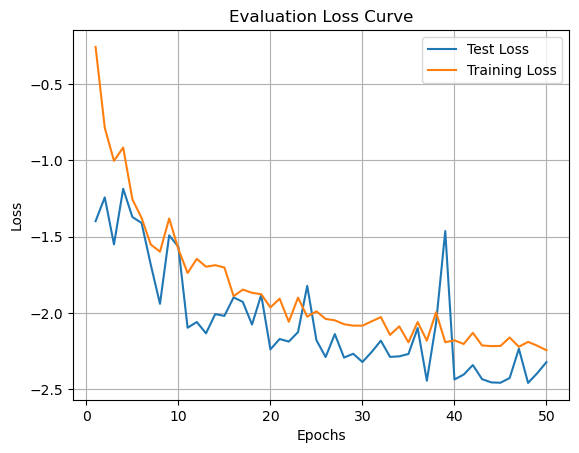

Mean Squared Error (MSE): 0.51270991563797
R-squared: 0.24901155800536418
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=3, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=8, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: -0.6112068834081292
Epoch [1/50], Test Loss: -1.1541404213905335
Epoch [2/50], Training Loss: -1.1433231410756708
Epoch [2/50], Test Loss: -1.4509749603271485
Epoch [3/50], Training Loss: -1.3249781617447733
Epoch [3/50], Test Loss: 0.644119713395834
Epoch [4/50], Training Loss: -1.3986600693240763
Epoch [4/50], Test Loss: -1.5750179948806762
Epoch [5/50], Training Loss: -1.4837475669831037
Epoch [5/50], Test Loss: -1.6610327935218812
Epoch [6/50], Training Loss: -1.6027972979545593

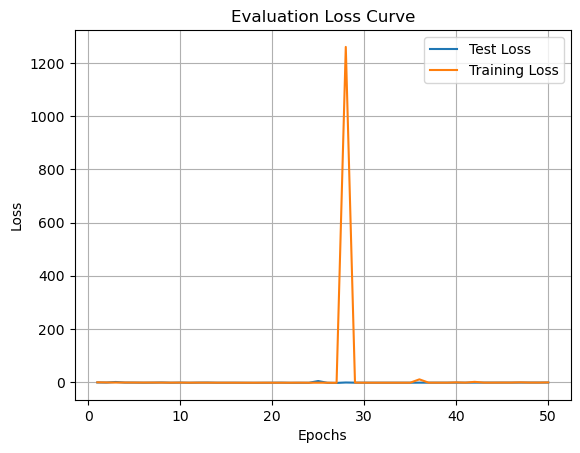

Mean Squared Error (MSE): 0.5093637704849243
R-squared: -0.0022008068301342387
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=3, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=8, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: -0.5264548087477684
Epoch [1/50], Test Loss: -1.0890532316872106
Epoch [2/50], Training Loss: -1.2872578633069993
Epoch [2/50], Test Loss: -1.834617499726268
Epoch [3/50], Training Loss: -1.1607256111979485
Epoch [3/50], Test Loss: -1.571658768592932
Epoch [4/50], Training Loss: -1.2105499930381776
Epoch [4/50], Test Loss: -1.64501181616189
Epoch [5/50], Training Loss: -1.5331552485704423
Epoch [5/50], Test Loss: -1.413221764488342
Epoch [6/50], Training Loss: -1.62213289265036

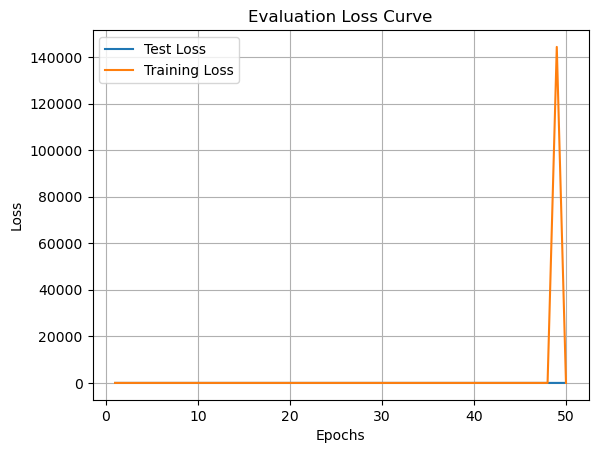

Mean Squared Error (MSE): 0.49982768297195435
R-squared: 0.24979830898707933
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=3, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=8, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: 0.03550102663040161
Epoch [1/50], Test Loss: -0.9795617962640429
Epoch [2/50], Training Loss: -0.10808368974924087
Epoch [2/50], Test Loss: -0.21540951705168163
Epoch [3/50], Training Loss: -0.5463283530771732
Epoch [3/50], Test Loss: -0.7626383418128604
Epoch [4/50], Training Loss: -0.7169002733528614
Epoch [4/50], Test Loss: -0.9284206165207757
Epoch [5/50], Training Loss: -0.7815100765824318
Epoch [5/50], Test Loss: -0.6893661230329483
Epoch [6/50], Training Loss: -0.830601146

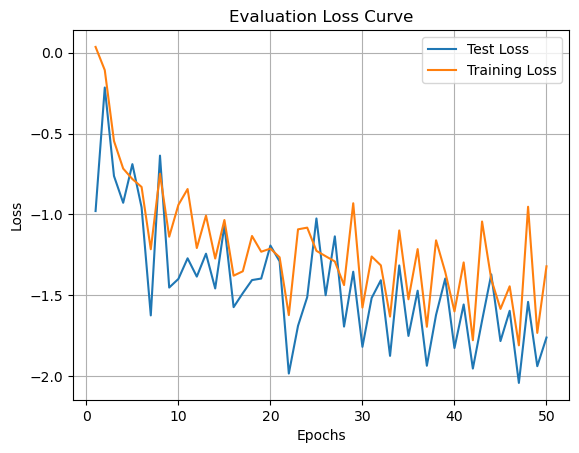

Mean Squared Error (MSE): 0.5143617391586304
R-squared: -0.004452358280524482
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=3, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=8, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: -0.020571248158812522
Epoch [1/50], Test Loss: -0.6466973595619202
Epoch [2/50], Training Loss: -0.6341414839327335
Epoch [2/50], Test Loss: -0.2211121345758438
Epoch [3/50], Training Loss: -0.8808159693479538
Epoch [3/50], Test Loss: -1.1951590118408204
Epoch [4/50], Training Loss: -0.8875514998883008
Epoch [4/50], Test Loss: -1.4604199485778808
Epoch [5/50], Training Loss: -0.7568887001872062
Epoch [5/50], Test Loss: -1.5489730243682862
Epoch [6/50], Training Loss: -1.00492872

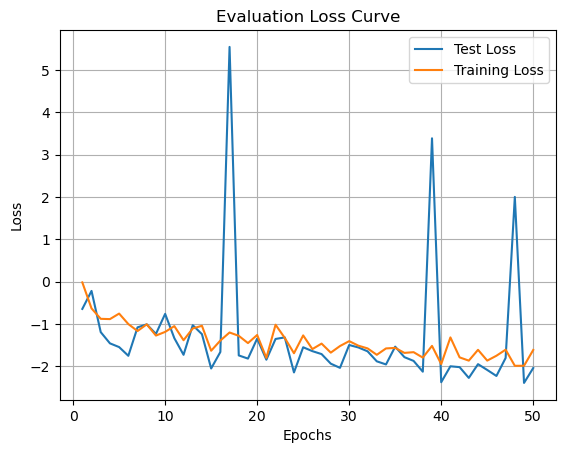

Mean Squared Error (MSE): 0.4874277412891388
R-squared: -0.0003384616249880179
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=3, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=8, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: -0.2957546217193206
Epoch [1/50], Test Loss: -0.5136148477805421
Epoch [2/50], Training Loss: -0.8516875798602899
Epoch [2/50], Test Loss: -0.9859963154539149
Epoch [3/50], Training Loss: -1.0568341852625212
Epoch [3/50], Test Loss: -1.2215181100875774
Epoch [4/50], Training Loss: -1.048279974957307
Epoch [4/50], Test Loss: -1.3684399140642045
Epoch [5/50], Training Loss: -1.0669551646312079
Epoch [5/50], Test Loss: -1.0092639644095238
Epoch [6/50], Training Loss: -1.2315811026

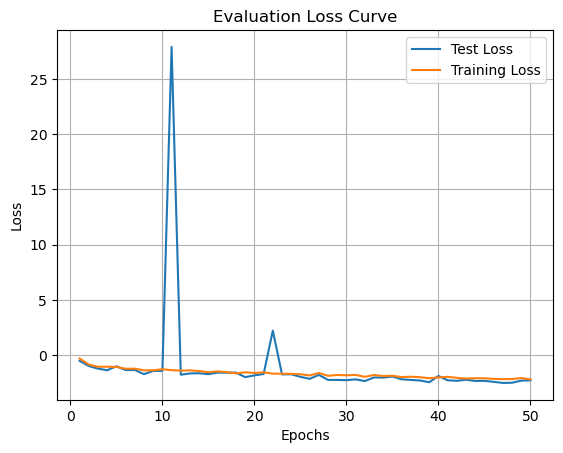

Mean Squared Error (MSE): 0.4872991740703583
R-squared: -0.000862189657404866
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=3, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=8, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: -0.44716073673218487
Epoch [1/50], Test Loss: -1.0123011412620544
Epoch [2/50], Training Loss: -0.758921030730009
Epoch [2/50], Test Loss: -1.0305303738117217
Epoch [3/50], Training Loss: -0.9014850887805224
Epoch [3/50], Test Loss: -1.4460956931114197
Epoch [4/50], Training Loss: -1.1872725535109638
Epoch [4/50], Test Loss: -1.3413312439918519
Epoch [5/50], Training Loss: -1.0711576512530445
Epoch [5/50], Test Loss: -1.6380618753433227
Epoch [6/50], Training Loss: -1.2280203007

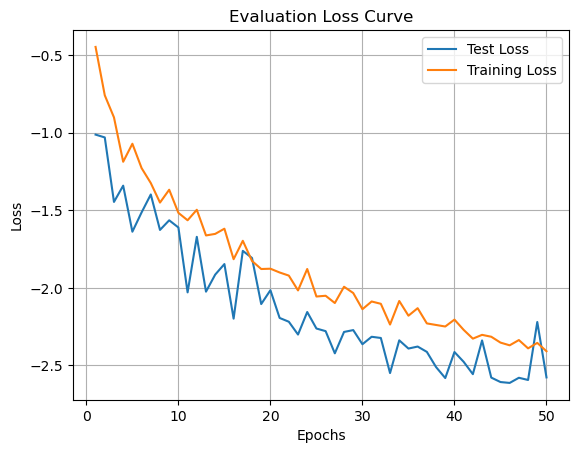

Mean Squared Error (MSE): 0.5070443749427795
R-squared: -0.001544985016423972
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=3, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=8, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: -0.4053767633855343
Epoch [1/50], Test Loss: -0.19469238670108419
Epoch [2/50], Training Loss: -0.8075787025213241
Epoch [2/50], Test Loss: -1.0060953916833042
Epoch [3/50], Training Loss: -1.1118912468552589
Epoch [3/50], Test Loss: -1.3539934927663102
Epoch [4/50], Training Loss: -1.2500188966035843
Epoch [4/50], Test Loss: -1.698029264093588
Epoch [5/50], Training Loss: -1.2154729239225388
Epoch [5/50], Test Loss: -1.068228132618121
Epoch [6/50], Training Loss: -1.33881751610

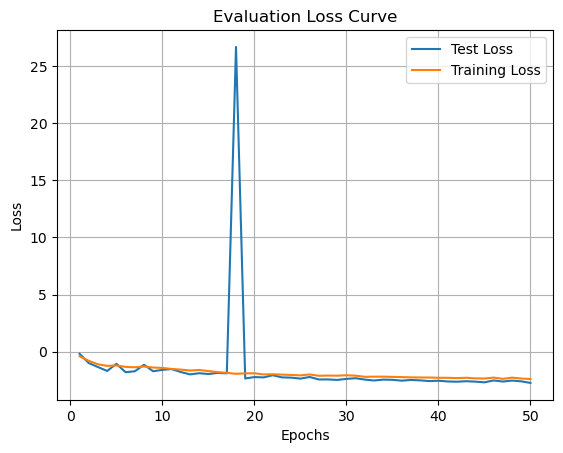

Mean Squared Error (MSE): 0.49776047468185425
R-squared: -0.00030879959481833197
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=4, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=10, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: 1.5943075795173645
Epoch [1/50], Test Loss: 1.0590754747390747
Epoch [2/50], Training Loss: 1.0228391296863555
Epoch [2/50], Test Loss: 0.8394321572212946
Epoch [3/50], Training Loss: 1.128951887845993
Epoch [3/50], Test Loss: 1.0788403437251137
Epoch [4/50], Training Loss: 0.859932133436203
Epoch [4/50], Test Loss: 0.80810422745962
Epoch [5/50], Training Loss: 0.78615456032753
Epoch [5/50], Test Loss: 1.1680778652902633
Epoch [6/50], Training Loss: 0.766297468662262
Epoch [

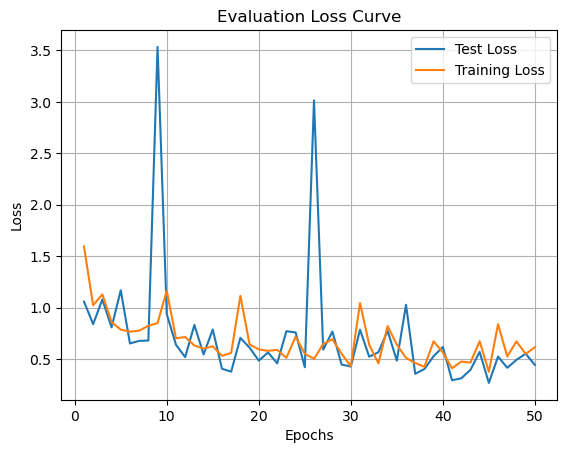

Mean Squared Error (MSE): 3.7532973289489746
R-squared: 0.11703304275816566
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=4, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=10, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: 1.3825138630867004
Epoch [1/50], Test Loss: 1.041054913043976
Epoch [2/50], Training Loss: 0.9594548691511154
Epoch [2/50], Test Loss: 0.7469070692062378
Epoch [3/50], Training Loss: 1.1084052203297614
Epoch [3/50], Test Loss: 0.9818527164459229
Epoch [4/50], Training Loss: 0.8675053176879883
Epoch [4/50], Test Loss: 0.6302211651802063
Epoch [5/50], Training Loss: 0.8388710845708847
Epoch [5/50], Test Loss: 1.2118935194015503
Epoch [6/50], Training Loss: 1.011857689857483
Epoch [

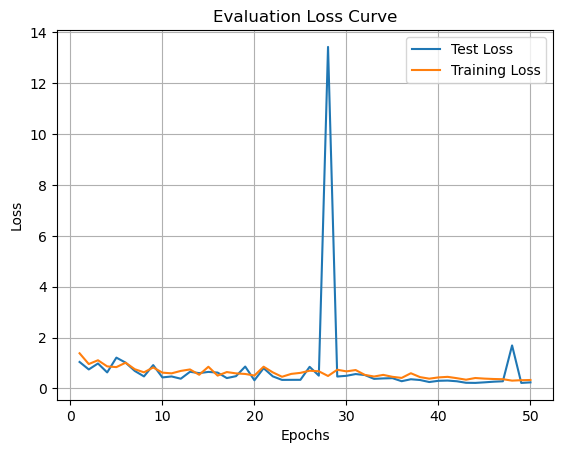

Mean Squared Error (MSE): 3.3101189136505127
R-squared: 0.1972608772112783
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=4, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=10, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: 1.2649222198327383
Epoch [1/50], Test Loss: 1.0471416825943805
Epoch [2/50], Training Loss: 0.8149438307682673
Epoch [2/50], Test Loss: 0.7895288879567004
Epoch [3/50], Training Loss: 0.7979441908995311
Epoch [3/50], Test Loss: 0.6451597873200762
Epoch [4/50], Training Loss: 0.7161800274848938
Epoch [4/50], Test Loss: 0.6142771965328683
Epoch [5/50], Training Loss: 0.6492835994958878
Epoch [5/50], Test Loss: 0.5846093119458949
Epoch [6/50], Training Loss: 0.6310939551591873
Epoch 

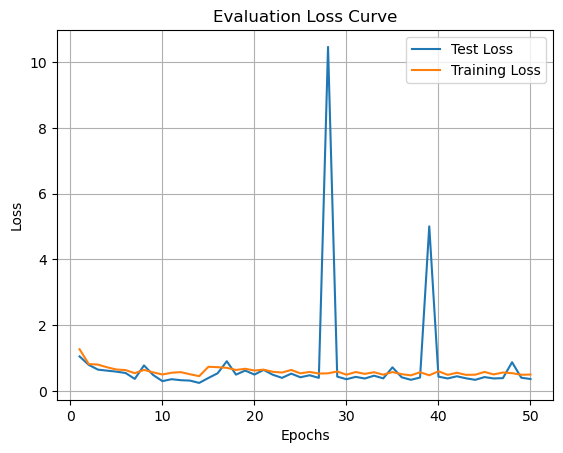

Mean Squared Error (MSE): 5.92425012588501
R-squared: -0.0011933721814433086
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=4, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=10, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: 1.1422895394563675
Epoch [1/50], Test Loss: 0.7249250712394715
Epoch [2/50], Training Loss: 0.762864023476839
Epoch [2/50], Test Loss: 0.5182490284442902
Epoch [3/50], Training Loss: 0.7527900007367134
Epoch [3/50], Test Loss: 0.7731590418815613
Epoch [4/50], Training Loss: 0.6725227465629577
Epoch [4/50], Test Loss: 0.45302143239974973
Epoch [5/50], Training Loss: 0.6470535693913698
Epoch [5/50], Test Loss: 0.37890660071372984
Epoch [6/50], Training Loss: 0.6366677373498678
Epo

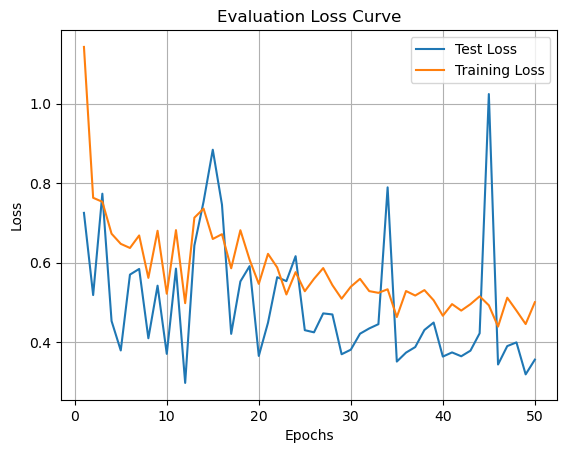

Mean Squared Error (MSE): 6.110688209533691
R-squared: -0.001202717828180555
EnsembleModel(
  (activation): ReLU()
  (ensemble_models): ModuleList(
    (0-4): 5 x Sequential(
      (0): Linear(in_features=4, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): Linear(in_features=20, out_features=10, bias=True)
    )
  )
)
Epoch [1/50], Training Loss: 1.1748170239448548
Epoch [1/50], Test Loss: 0.721010691441667
Epoch [2/50], Training Loss: 0.7887138219118118
Epoch [2/50], Test Loss: 0.5340841555366882
Epoch [3/50], Training Loss: 0.7226512899875641
Epoch [3/50], Test Loss: 0.43742179584960206
Epoch [4/50], Training Loss: 0.7491572752714157
Epoch [4/50], Test Loss: 1.1655597901953676
Epoch [5/50], Training Loss: 0.7652626735687256
Epoch [5/50], Test Loss: 0.6107186365622682
Epoch [6/50], Training Loss: 0.6775931809902191
Epoc

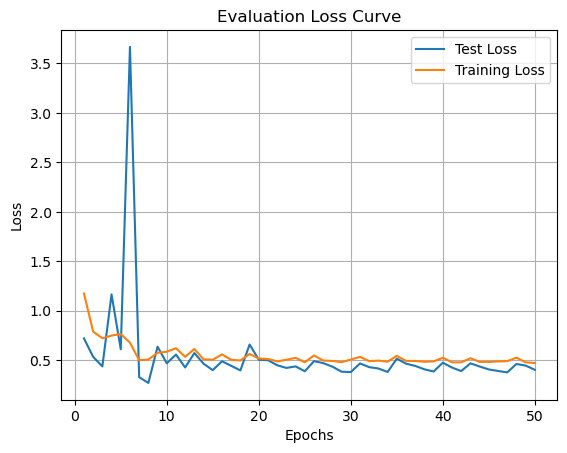

Mean Squared Error (MSE): 6.904465675354004
R-squared: -0.0061206243895110205


In [4]:
env_names = ['CartPole-v1', 'MountainCarContinuous-v0', 'MountainCar-v0', 'Pendulum-v1']
num_samples_list = ['10k', '20k', '30k', '40k', '50k']

for env_name in env_names:

    env = gym.make(env_name)
    batch_size = 32


    for num_samples in num_samples_list:
        # Load datasets
        with open(env_name + '_' + num_samples + '_train_dataset.pkl', 'rb') as f:
            train_dataset_loaded = pickle.load(f)

        with open(env_name + '_' + num_samples + '_test_dataset.pkl', 'rb') as f:
            test_dataset_loaded = pickle.load(f)

        train_loader = torch.utils.data.DataLoader(train_dataset_loaded, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset_loaded, batch_size=batch_size, shuffle=False)
        
        #Initialize parameters for model
        action = env.action_space.sample()

        if isinstance(action, int):
            input_size = env.observation_space.shape[0] + 1
        elif isinstance(action, np.ndarray):
            input_size = env.observation_space.shape[0] + len(action)

        output_size = 2*(env.observation_space.shape[0] + 2)
        num_layers = 3
        num_nodes = 20
        activation = nn.ReLU()
        num_ensembles = 5
        learning_rate = 0.01

        model = EnsembleModel(input_size, output_size, num_layers, num_nodes, activation, num_ensembles).to(device)
        print(model)


        # Define loss function and optimizer
        criterion = gaussian_likelihood
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop with evaluation
        num_epochs = 50
        train_losses = []
        test_losses = []
        save_interval = 100
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                mean_pred, std_pred = model(inputs)
                loss = criterion(mean_pred, std_pred, labels)

                if torch.isnan(loss).any():
                    print("NaN detected during training")
                    print("Inputs:", inputs)
                    print("Mean Prediction:", mean_pred)
                    print("Std Prediction:", std_pred)
                    break

                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            if torch.isnan(loss).any():
                torch.save(model.state_dict(), f'pets_{env_name}_epoch_{epoch+1}.pth')
                break
            epoch_train_loss = running_loss / len(train_loader)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_train_loss}")
            train_losses.append(epoch_train_loss)

            # Evaluation on test data
            #model.eval()
            running_test_loss = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    mean_pred, std_pred = model(inputs)
                    test_loss = criterion(mean_pred, std_pred, labels)
                    running_test_loss += test_loss.item()
            epoch_test_loss = running_test_loss / len(test_loader)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {epoch_test_loss}")

            if (epoch + 1) % save_interval == 0:
                # Save model state
                torch.save(model.state_dict(), f'pets_{env_name}_{num_samples}_epoch_{epoch+1}.pth')

            test_losses.append(epoch_test_loss)
            
            
        # Plotting the evaluation loss curve
        plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
        plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Evaluation Loss Curve')
        plt.legend()
        plt.grid(True)
        # Save the plot
        plt.savefig('pets_'+ env_name + '_' + num_samples + '_evaluation_loss_curve.png')
        plt.show()
        
        predictions = []
        true_labels = []

        # Iterate over test data
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                #predictions.extend(outputs.cpu().numpy())
                #true_labels.extend(labels.cpu().numpy())
                #predictions.extend(outputs)
                #true_labels.extend(labels)
                prediction_tensor = outputs[0].cpu()
                predictions.extend(prediction_tensor.numpy())
                true_labels.extend(labels.cpu().numpy())

        # Convert lists to numpy arrays
        predictions = np.array(predictions)
        true_labels = np.array(true_labels)

        # Calculate Mean Squared Error (MSE) and R-squared
        mse = mean_squared_error(true_labels, predictions)
        r2 = r2_score(true_labels, predictions)

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"R-squared: {r2}")
        
        model_weights_file_path = 'pets_'+ env_name + '_' + num_samples +'.pth' 
        # Save the trained model
        torch.save(model.state_dict(), model_weights_file_path)

# Monte Carlo Dropout for all samples

In [9]:
import gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn
from sklearn.metrics import mean_squared_error, r2_score

import pickle

import os

In [10]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
class MC_Dropout_Net(nn.Module):
    def __init__(self, input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation, dropout_prob, num_network):
        super(MC_Dropout_Net, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_nodes = hidden_layer_nodes
        self.activation = activation
        self.num_network = num_network
        
        # Define the layers
        self.input_layer = nn.Linear(input_size, hidden_layer_nodes)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_layer_nodes, hidden_layer_nodes))
            self.hidden_layers.append(nn.Dropout(p=dropout_prob))
        self.output_layer = nn.Linear(hidden_layer_nodes, output_size)

    def forward(self, x):
        total_output = 0.0
        for i in range(self.num_network):
            x_temp = x
            x_temp = self.activation(self.input_layer(x_temp))
            for hidden_layer in self.hidden_layers:
                x_temp = self.activation(hidden_layer(x_temp))
            output = self.output_layer(x_temp)
            total_output += output
        average_output = total_output / self.num_network
        return average_output


Epoch [1/50], Training Loss: 0.78592669536393
Epoch [1/50], Test Loss: 0.7811127342875042
Epoch [2/50], Training Loss: 0.7696203957515884
Epoch [2/50], Test Loss: 0.7794673338768974
Epoch [3/50], Training Loss: 0.7673471381227334
Epoch [3/50], Test Loss: 0.7948122828725784
Epoch [4/50], Training Loss: 0.7710408751233165
Epoch [4/50], Test Loss: 0.7895798900770763
Epoch [5/50], Training Loss: 0.767219585845195
Epoch [5/50], Test Loss: 0.7799986496804252
Epoch [6/50], Training Loss: 0.766503970936475
Epoch [6/50], Test Loss: 0.7826873404639108
Epoch [7/50], Training Loss: 0.768248566593307
Epoch [7/50], Test Loss: 0.7817227660663544
Epoch [8/50], Training Loss: 0.7655565460839594
Epoch [8/50], Test Loss: 0.7812308148732261
Epoch [9/50], Training Loss: 0.7658150851489063
Epoch [9/50], Test Loss: 0.7880721480127365
Epoch [10/50], Training Loss: 0.7665746076648454
Epoch [10/50], Test Loss: 0.7835685610771179
Epoch [11/50], Training Loss: 0.7656139648293119
Epoch [11/50], Test Loss: 0.780629

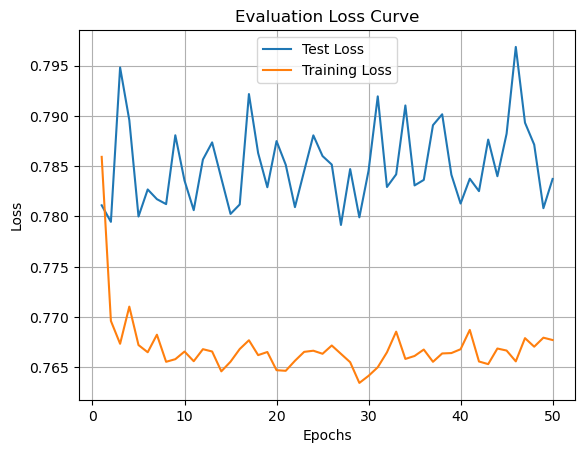

Mean Squared Error (MSE): 0.7856914401054382
R-squared: 0.05942008222013173
Epoch [1/50], Training Loss: 0.7806044236390652
Epoch [1/50], Test Loss: 0.7671491801738739
Epoch [2/50], Training Loss: 0.7697192765995414
Epoch [2/50], Test Loss: 0.7656393254560138
Epoch [3/50], Training Loss: 0.7697525988081972
Epoch [3/50], Test Loss: 0.7627554673051077
Epoch [4/50], Training Loss: 0.7689629605192386
Epoch [4/50], Test Loss: 0.7643821348273565
Epoch [5/50], Training Loss: 0.7684591237061514
Epoch [5/50], Test Loss: 0.7649587634063902
Epoch [6/50], Training Loss: 0.767151576911142
Epoch [6/50], Test Loss: 0.7667052632286435
Epoch [7/50], Training Loss: 0.7680579762972758
Epoch [7/50], Test Loss: 0.7631750877887483
Epoch [8/50], Training Loss: 0.7686224971226827
Epoch [8/50], Test Loss: 0.7659452609599583
Epoch [9/50], Training Loss: 0.7687416017174483
Epoch [9/50], Test Loss: 0.7649008090060855
Epoch [10/50], Training Loss: 0.7679218010393207
Epoch [10/50], Test Loss: 0.768254314150129
Epoc

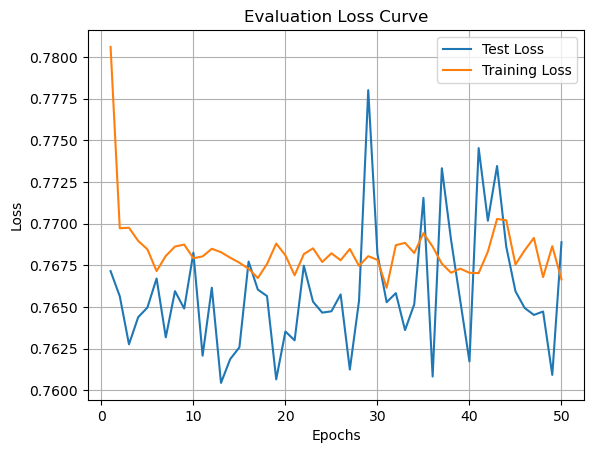

Mean Squared Error (MSE): 0.767853319644928
R-squared: 0.04586362810240271
Epoch [1/50], Training Loss: 0.781655599845551
Epoch [1/50], Test Loss: 0.7647639237185742
Epoch [2/50], Training Loss: 0.7737239592084872
Epoch [2/50], Test Loss: 0.7610578885737885
Epoch [3/50], Training Loss: 0.7716303926492023
Epoch [3/50], Test Loss: 0.7670206120039554
Epoch [4/50], Training Loss: 0.7733268621917094
Epoch [4/50], Test Loss: 0.7664434912991016
Epoch [5/50], Training Loss: 0.7733056920663653
Epoch [5/50], Test Loss: 0.7710316824786206
Epoch [6/50], Training Loss: 0.7725705134567027
Epoch [6/50], Test Loss: 0.7672347908324384
Epoch [7/50], Training Loss: 0.7726788085087956
Epoch [7/50], Test Loss: 0.7683204570983319
Epoch [8/50], Training Loss: 0.7726856045494385
Epoch [8/50], Test Loss: 0.7640415182773103
Epoch [9/50], Training Loss: 0.773194762901682
Epoch [9/50], Test Loss: 0.7652133696890892
Epoch [10/50], Training Loss: 0.7724505120047558
Epoch [10/50], Test Loss: 0.7630550109959663
Epoch

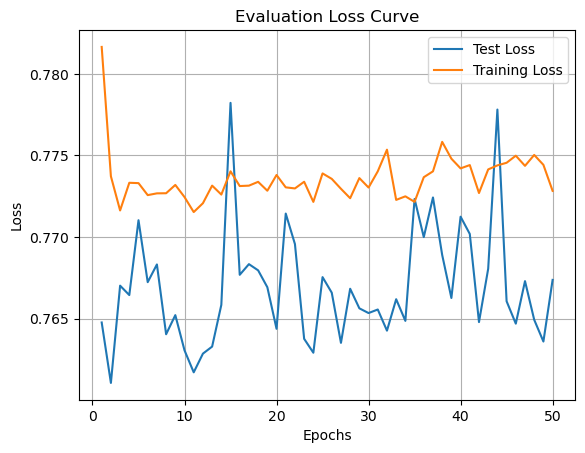

Mean Squared Error (MSE): 0.7658769488334656
R-squared: 0.04868834086109031
Epoch [1/50], Training Loss: 0.7823097807663185
Epoch [1/50], Test Loss: 0.7631704016510709
Epoch [2/50], Training Loss: 0.7722008209247571
Epoch [2/50], Test Loss: 0.7652999865581315
Epoch [3/50], Training Loss: 0.7718929233072283
Epoch [3/50], Test Loss: 0.7667399944062252
Epoch [4/50], Training Loss: 0.772084081952984
Epoch [4/50], Test Loss: 0.7739920430924313
Epoch [5/50], Training Loss: 0.7727638907604046
Epoch [5/50], Test Loss: 0.7641801133573768
Epoch [6/50], Training Loss: 0.7710209226274823
Epoch [6/50], Test Loss: 0.7640412487831724
Epoch [7/50], Training Loss: 0.7744060560658976
Epoch [7/50], Test Loss: 0.7664604707068181
Epoch [8/50], Training Loss: 0.7724245276960817
Epoch [8/50], Test Loss: 0.765095366662242
Epoch [9/50], Training Loss: 0.7726953076673198
Epoch [9/50], Test Loss: 0.7616921831887081
Epoch [10/50], Training Loss: 0.7709219284824558
Epoch [10/50], Test Loss: 0.7656917289433727
Epoc

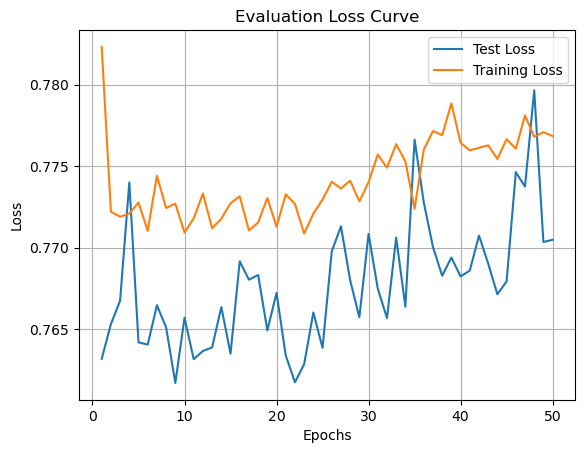

Mean Squared Error (MSE): 0.7713856101036072
R-squared: 0.046642612503011494
Epoch [1/50], Training Loss: 0.7782300931277225
Epoch [1/50], Test Loss: 0.7769997496955311
Epoch [2/50], Training Loss: 0.7707647178575194
Epoch [2/50], Test Loss: 0.7749214434204772
Epoch [3/50], Training Loss: 0.7711353796801502
Epoch [3/50], Test Loss: 0.7782205046175387
Epoch [4/50], Training Loss: 0.7696431356844761
Epoch [4/50], Test Loss: 0.7742430666765086
Epoch [5/50], Training Loss: 0.7699568975362465
Epoch [5/50], Test Loss: 0.7753589646503948
Epoch [6/50], Training Loss: 0.7705691946115044
Epoch [6/50], Test Loss: 0.786789384893716
Epoch [7/50], Training Loss: 0.7691103818891145
Epoch [7/50], Test Loss: 0.7749865443561785
Epoch [8/50], Training Loss: 0.7695029219753927
Epoch [8/50], Test Loss: 0.7804240572947664
Epoch [9/50], Training Loss: 0.7697350631991355
Epoch [9/50], Test Loss: 0.7820121164139087
Epoch [10/50], Training Loss: 0.7705106942011394
Epoch [10/50], Test Loss: 0.7808622864488596
Ep

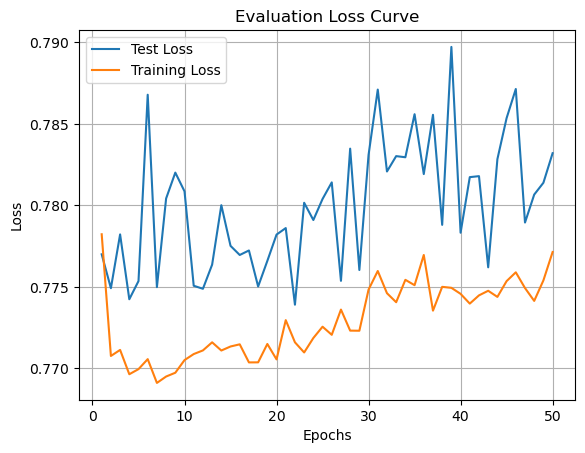

Mean Squared Error (MSE): 0.7798014283180237
R-squared: 0.04808189572419443
Epoch [1/50], Training Loss: 0.5018975946307183
Epoch [1/50], Test Loss: 0.5147776125915466
Epoch [2/50], Training Loss: 0.4951809265613556
Epoch [2/50], Test Loss: 0.5115130378140343
Epoch [3/50], Training Loss: 0.49523295676708223
Epoch [3/50], Test Loss: 0.5153716447807494
Epoch [4/50], Training Loss: 0.4953941618204117
Epoch [4/50], Test Loss: 0.5116837686962552
Epoch [5/50], Training Loss: 0.49436391532421115
Epoch [5/50], Test Loss: 0.5119240350193448
Epoch [6/50], Training Loss: 0.4951525478363037
Epoch [6/50], Test Loss: 0.5101755261421204
Epoch [7/50], Training Loss: 0.4943665212392807
Epoch [7/50], Test Loss: 0.5116848955078731
Epoch [8/50], Training Loss: 0.4943049649000168
Epoch [8/50], Test Loss: 0.5101317678179059
Epoch [9/50], Training Loss: 0.49412137603759765
Epoch [9/50], Test Loss: 0.5104773915003217
Epoch [10/50], Training Loss: 0.4943074530363083
Epoch [10/50], Test Loss: 0.512121405866411


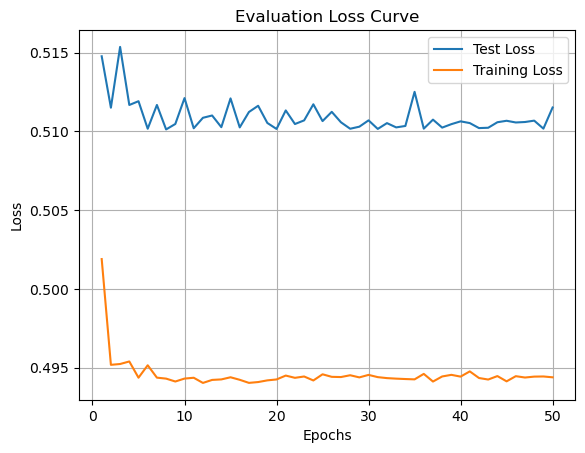

Mean Squared Error (MSE): 0.5116711854934692
R-squared: -0.004287178730843444
Epoch [1/50], Training Loss: 0.510143497467041
Epoch [1/50], Test Loss: 0.4965121715068817
Epoch [2/50], Training Loss: 0.5078255723118782
Epoch [2/50], Test Loss: 0.4945239086151123
Epoch [3/50], Training Loss: 0.5074919342398644
Epoch [3/50], Test Loss: 0.49443036341667174
Epoch [4/50], Training Loss: 0.507257184267044
Epoch [4/50], Test Loss: 0.49427317261695863
Epoch [5/50], Training Loss: 0.507347000002861
Epoch [5/50], Test Loss: 0.49429782867431643
Epoch [6/50], Training Loss: 0.5072918635606766
Epoch [6/50], Test Loss: 0.4952631597518921
Epoch [7/50], Training Loss: 0.5072327905893326
Epoch [7/50], Test Loss: 0.494198620557785
Epoch [8/50], Training Loss: 0.5073592538833618
Epoch [8/50], Test Loss: 0.49426981377601625
Epoch [9/50], Training Loss: 0.507180947303772
Epoch [9/50], Test Loss: 0.4948503530025482
Epoch [10/50], Training Loss: 0.5073494449853897
Epoch [10/50], Test Loss: 0.4943366913795471
E

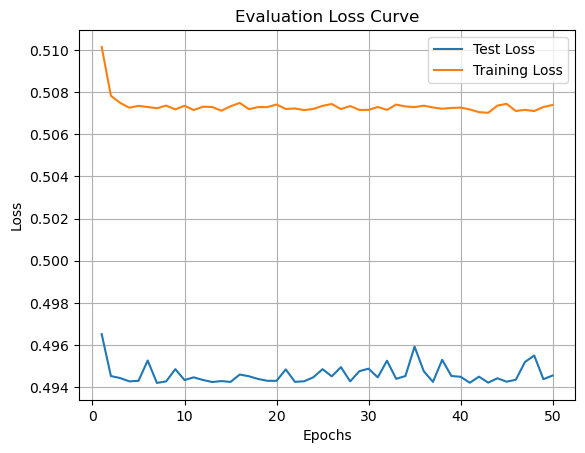

Mean Squared Error (MSE): 0.49455055594444275
R-squared: -0.0050651074920972095
Epoch [1/50], Training Loss: 0.5059052580595016
Epoch [1/50], Test Loss: 0.513118138972749
Epoch [2/50], Training Loss: 0.5040050019820531
Epoch [2/50], Test Loss: 0.5134626625383154
Epoch [3/50], Training Loss: 0.5037845520575841
Epoch [3/50], Test Loss: 0.513070875184333
Epoch [4/50], Training Loss: 0.5035530670086543
Epoch [4/50], Test Loss: 0.5131770748090236
Epoch [5/50], Training Loss: 0.5035557268857956
Epoch [5/50], Test Loss: 0.5132736390892495
Epoch [6/50], Training Loss: 0.5035984037717184
Epoch [6/50], Test Loss: 0.5130117686187967
Epoch [7/50], Training Loss: 0.5036662950913111
Epoch [7/50], Test Loss: 0.5129722467762359
Epoch [8/50], Training Loss: 0.5035860160986583
Epoch [8/50], Test Loss: 0.513185829241225
Epoch [9/50], Training Loss: 0.503638307650884
Epoch [9/50], Test Loss: 0.5134126802391195
Epoch [10/50], Training Loss: 0.5035637751420339
Epoch [10/50], Test Loss: 0.5131280450744832
Ep

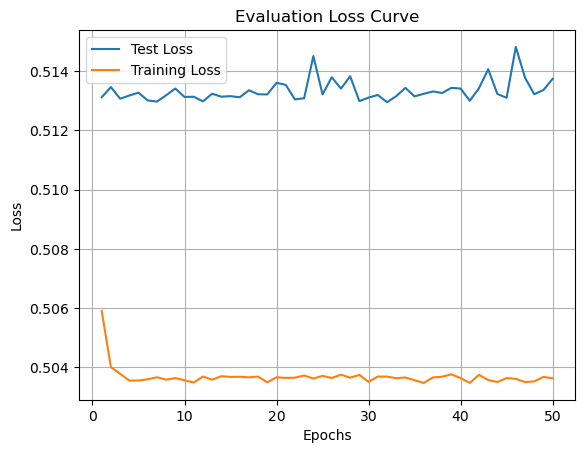

Mean Squared Error (MSE): 0.5131031274795532
R-squared: -0.016196585877036818
Epoch [1/50], Training Loss: 0.5042753928005695
Epoch [1/50], Test Loss: 0.5092987982034684
Epoch [2/50], Training Loss: 0.5031807419359684
Epoch [2/50], Test Loss: 0.5094481835365295
Epoch [3/50], Training Loss: 0.5031065679192543
Epoch [3/50], Test Loss: 0.509186919927597
Epoch [4/50], Training Loss: 0.5030808866620063
Epoch [4/50], Test Loss: 0.5095506399869919
Epoch [5/50], Training Loss: 0.5031133253872394
Epoch [5/50], Test Loss: 0.5091349097490311
Epoch [6/50], Training Loss: 0.503005968272686
Epoch [6/50], Test Loss: 0.509596952199936
Epoch [7/50], Training Loss: 0.5030841581225395
Epoch [7/50], Test Loss: 0.5100702228546142
Epoch [8/50], Training Loss: 0.503114177763462
Epoch [8/50], Test Loss: 0.5094652947187424
Epoch [9/50], Training Loss: 0.5030762555599213
Epoch [9/50], Test Loss: 0.5091418182849884
Epoch [10/50], Training Loss: 0.5030330947935581
Epoch [10/50], Test Loss: 0.5091642441749573
Epoc

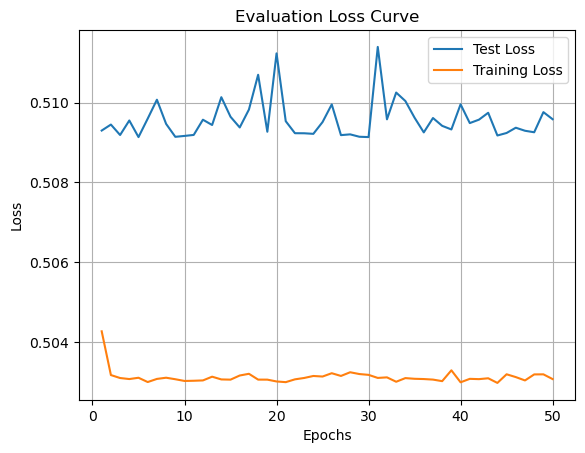

Mean Squared Error (MSE): 0.509581446647644
R-squared: -0.0014671489543103822
Epoch [1/50], Training Loss: 0.503040199136734
Epoch [1/50], Test Loss: 0.5016233056498031
Epoch [2/50], Training Loss: 0.5013337506890297
Epoch [2/50], Test Loss: 0.500110787229416
Epoch [3/50], Training Loss: 0.5012854189395904
Epoch [3/50], Test Loss: 0.5001726792262385
Epoch [4/50], Training Loss: 0.501481995844841
Epoch [4/50], Test Loss: 0.5002560397497
Epoch [5/50], Training Loss: 0.5013680311441422
Epoch [5/50], Test Loss: 0.5000851166705353
Epoch [6/50], Training Loss: 0.5012688432216644
Epoch [6/50], Test Loss: 0.5000559498136417
Epoch [7/50], Training Loss: 0.5012652019262314
Epoch [7/50], Test Loss: 0.5001693742153362
Epoch [8/50], Training Loss: 0.5013871591806411
Epoch [8/50], Test Loss: 0.5001656486393925
Epoch [9/50], Training Loss: 0.5014076374530793
Epoch [9/50], Test Loss: 0.5018094651424847
Epoch [10/50], Training Loss: 0.5012967369794845
Epoch [10/50], Test Loss: 0.50022762775802
Epoch [1

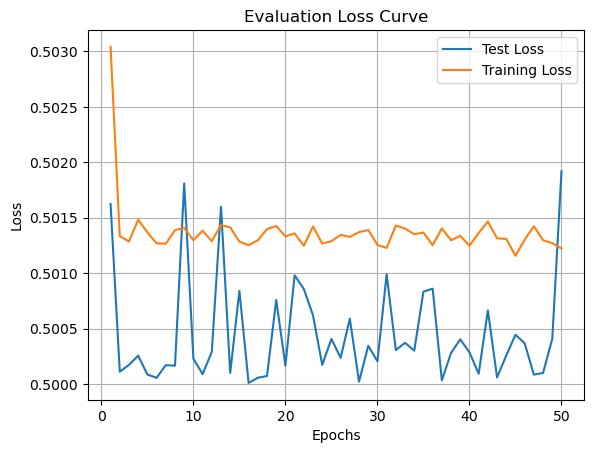

Mean Squared Error (MSE): 0.5017012357711792
R-squared: -0.001962573050769023
Epoch [1/50], Training Loss: 0.5159333239793777
Epoch [1/50], Test Loss: 0.5138059362532601
Epoch [2/50], Training Loss: 0.5107279097437859
Epoch [2/50], Test Loss: 0.5109863584003751
Epoch [3/50], Training Loss: 0.5096675915718079
Epoch [3/50], Test Loss: 0.5152981584034269
Epoch [4/50], Training Loss: 0.5094018471240997
Epoch [4/50], Test Loss: 0.5100438064999051
Epoch [5/50], Training Loss: 0.5092261785268783
Epoch [5/50], Test Loss: 0.511619748577239
Epoch [6/50], Training Loss: 0.5087335686683655
Epoch [6/50], Test Loss: 0.5104005932807922
Epoch [7/50], Training Loss: 0.5086229453086853
Epoch [7/50], Test Loss: 0.5103108239552331
Epoch [8/50], Training Loss: 0.5084543695449829
Epoch [8/50], Test Loss: 0.5102260524318332
Epoch [9/50], Training Loss: 0.5083840436935425
Epoch [9/50], Test Loss: 0.5104447962745787
Epoch [10/50], Training Loss: 0.5081859114170074
Epoch [10/50], Test Loss: 0.5103244809877305
E

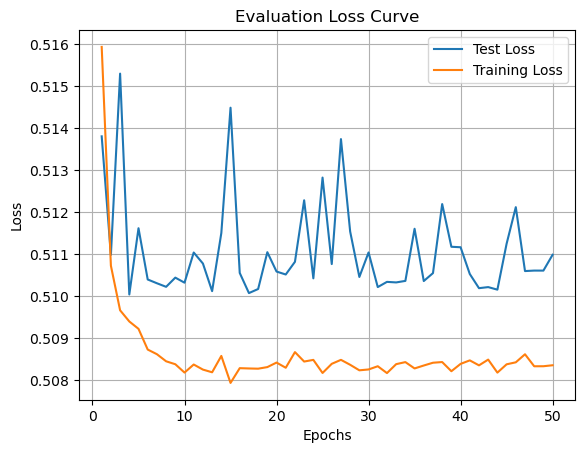

Mean Squared Error (MSE): 0.5108053684234619
R-squared: 0.2491070317007829
Epoch [1/50], Training Loss: 0.5113262358903885
Epoch [1/50], Test Loss: 0.48834496521949766
Epoch [2/50], Training Loss: 0.5078155669569969
Epoch [2/50], Test Loss: 0.48825552344322204
Epoch [3/50], Training Loss: 0.507539501786232
Epoch [3/50], Test Loss: 0.48806313395500184
Epoch [4/50], Training Loss: 0.5072503210008145
Epoch [4/50], Test Loss: 0.48713706731796264
Epoch [5/50], Training Loss: 0.5069831206202507
Epoch [5/50], Test Loss: 0.4873328647613525
Epoch [6/50], Training Loss: 0.5071250956654548
Epoch [6/50], Test Loss: 0.4882477569580078
Epoch [7/50], Training Loss: 0.5070881946086884
Epoch [7/50], Test Loss: 0.4881641781330109
Epoch [8/50], Training Loss: 0.5071588368415832
Epoch [8/50], Test Loss: 0.4874149219989777
Epoch [9/50], Training Loss: 0.5072294840812683
Epoch [9/50], Test Loss: 0.4874987874031067
Epoch [10/50], Training Loss: 0.507029249548912
Epoch [10/50], Test Loss: 0.488171373128891
Ep

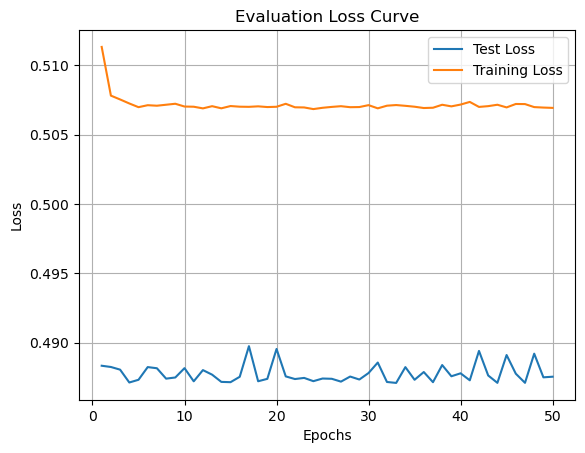

Mean Squared Error (MSE): 0.4875536859035492
R-squared: 0.24953934816308931
Epoch [1/50], Training Loss: 0.5136677603324254
Epoch [1/50], Test Loss: 0.48772873650205895
Epoch [2/50], Training Loss: 0.5074376185735067
Epoch [2/50], Test Loss: 0.4872173177117997
Epoch [3/50], Training Loss: 0.5068677798112233
Epoch [3/50], Test Loss: 0.48717703400774204
Epoch [4/50], Training Loss: 0.5066506458322207
Epoch [4/50], Test Loss: 0.48808290524051545
Epoch [5/50], Training Loss: 0.5068774152199428
Epoch [5/50], Test Loss: 0.48807774959726535
Epoch [6/50], Training Loss: 0.5069158871173859
Epoch [6/50], Test Loss: 0.48705170414549237
Epoch [7/50], Training Loss: 0.5066453619798025
Epoch [7/50], Test Loss: 0.4869611862492054
Epoch [8/50], Training Loss: 0.5067734872102737
Epoch [8/50], Test Loss: 0.4867166740463135
Epoch [9/50], Training Loss: 0.5068319831291834
Epoch [9/50], Test Loss: 0.48679583091685114
Epoch [10/50], Training Loss: 0.5067443644205729
Epoch [10/50], Test Loss: 0.4867323933446

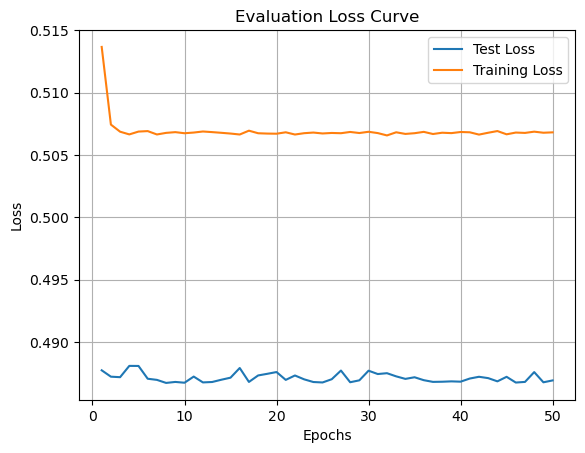

Mean Squared Error (MSE): 0.4866655766963959
R-squared: 0.24979324848085738
Epoch [1/50], Training Loss: 0.5064343120753765
Epoch [1/50], Test Loss: 0.5066118137836456
Epoch [2/50], Training Loss: 0.5035730965733528
Epoch [2/50], Test Loss: 0.5055995488166809
Epoch [3/50], Training Loss: 0.5035704113841056
Epoch [3/50], Test Loss: 0.505496551156044
Epoch [4/50], Training Loss: 0.5036208260655403
Epoch [4/50], Test Loss: 0.5058045645952225
Epoch [5/50], Training Loss: 0.5036711739897728
Epoch [5/50], Test Loss: 0.505700453877449
Epoch [6/50], Training Loss: 0.5035948778986931
Epoch [6/50], Test Loss: 0.5063792917728424
Epoch [7/50], Training Loss: 0.5036259239912033
Epoch [7/50], Test Loss: 0.5061129040718079
Epoch [8/50], Training Loss: 0.5035046300888062
Epoch [8/50], Test Loss: 0.5061606668233871
Epoch [9/50], Training Loss: 0.5034184715151787
Epoch [9/50], Test Loss: 0.5059650323390961
Epoch [10/50], Training Loss: 0.503710425645113
Epoch [10/50], Test Loss: 0.5058692940473557
Epoch

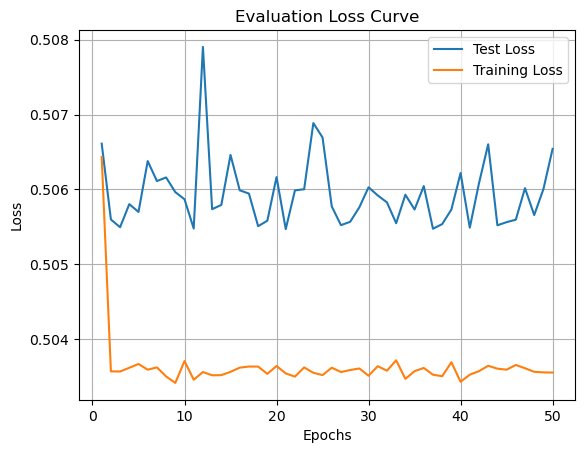

Mean Squared Error (MSE): 0.5065422058105469
R-squared: 0.24893086546368814
Epoch [1/50], Training Loss: 0.5018837982654571
Epoch [1/50], Test Loss: 0.49799890463915875
Epoch [2/50], Training Loss: 0.4986258335351944
Epoch [2/50], Test Loss: 0.4984554000936758
Epoch [3/50], Training Loss: 0.4984328178882599
Epoch [3/50], Test Loss: 0.4986091740786458
Epoch [4/50], Training Loss: 0.49852858951091766
Epoch [4/50], Test Loss: 0.49814852453268377
Epoch [5/50], Training Loss: 0.498249896979332
Epoch [5/50], Test Loss: 0.49792258498577263
Epoch [6/50], Training Loss: 0.4983989974975586
Epoch [6/50], Test Loss: 0.49889197060094476
Epoch [7/50], Training Loss: 0.4984352207422256
Epoch [7/50], Test Loss: 0.4988608821131551
Epoch [8/50], Training Loss: 0.4986219550251961
Epoch [8/50], Test Loss: 0.4981119627008042
Epoch [9/50], Training Loss: 0.4984716093540192
Epoch [9/50], Test Loss: 0.4991941011180512
Epoch [10/50], Training Loss: 0.49841994111537935
Epoch [10/50], Test Loss: 0.49819272994614

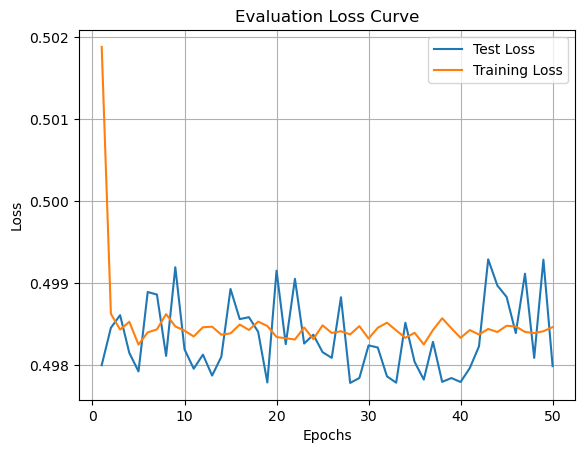

Mean Squared Error (MSE): 0.497683584690094
R-squared: 0.2497690263196285
Epoch [1/50], Training Loss: 3.528385806083679
Epoch [1/50], Test Loss: 3.4517500249166337
Epoch [2/50], Training Loss: 2.8838996295928956
Epoch [2/50], Test Loss: 3.4266142693776933
Epoch [3/50], Training Loss: 2.827488932132721
Epoch [3/50], Test Loss: 3.2725243076445563
Epoch [4/50], Training Loss: 2.7680616726875305
Epoch [4/50], Test Loss: 3.186483767297533
Epoch [5/50], Training Loss: 2.732120258808136
Epoch [5/50], Test Loss: 3.2375412782033286
Epoch [6/50], Training Loss: 2.7418549704551696
Epoch [6/50], Test Loss: 3.355433636241489
Epoch [7/50], Training Loss: 2.7215669374465943
Epoch [7/50], Test Loss: 3.0251643979360185
Epoch [8/50], Training Loss: 2.715243162155151
Epoch [8/50], Test Loss: 3.205882148137168
Epoch [9/50], Training Loss: 2.7023279824256896
Epoch [9/50], Test Loss: 3.2995053018842424
Epoch [10/50], Training Loss: 2.671881310939789
Epoch [10/50], Test Loss: 3.289519707361857
Epoch [11/50]

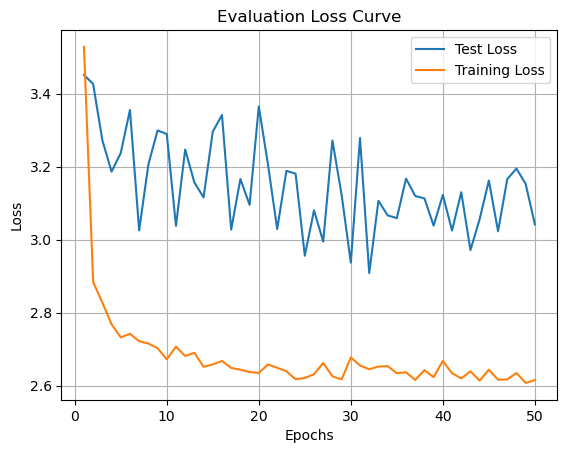

Mean Squared Error (MSE): 3.016491174697876
R-squared: 0.19820310046323475
Epoch [1/50], Training Loss: 3.1636642255783083
Epoch [1/50], Test Loss: 2.794759344100952
Epoch [2/50], Training Loss: 2.7936201839447024
Epoch [2/50], Test Loss: 2.8165055465698243
Epoch [3/50], Training Loss: 2.728384517669678
Epoch [3/50], Test Loss: 2.7770840396881105
Epoch [4/50], Training Loss: 2.6961119196414947
Epoch [4/50], Test Loss: 2.868462208747864
Epoch [5/50], Training Loss: 2.6774419016838076
Epoch [5/50], Test Loss: 2.8772471208572385
Epoch [6/50], Training Loss: 2.6805670099258423
Epoch [6/50], Test Loss: 2.7399731178283693
Epoch [7/50], Training Loss: 2.6734035551548003
Epoch [7/50], Test Loss: 2.7252821092605592
Epoch [8/50], Training Loss: 2.658981213569641
Epoch [8/50], Test Loss: 2.759076343536377
Epoch [9/50], Training Loss: 2.650306389570236
Epoch [9/50], Test Loss: 2.687555875778198
Epoch [10/50], Training Loss: 2.6534995193481445
Epoch [10/50], Test Loss: 2.7455724697113038
Epoch [11/

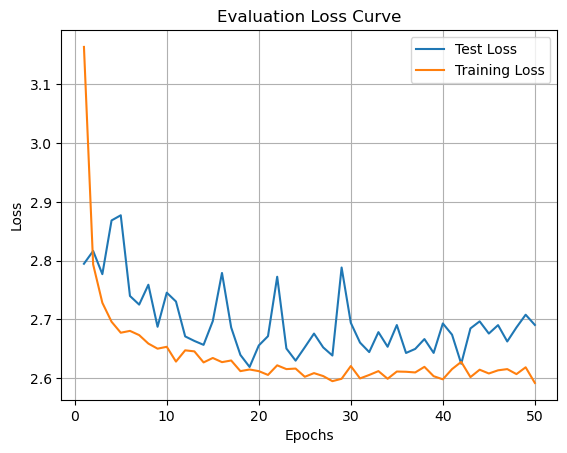

Mean Squared Error (MSE): 2.6634879112243652
R-squared: 0.2520755740582472
Epoch [1/50], Training Loss: 3.0570478099187217
Epoch [1/50], Test Loss: 2.745779572015113
Epoch [2/50], Training Loss: 2.7285916973749798
Epoch [2/50], Test Loss: 2.701984607792915
Epoch [3/50], Training Loss: 2.7184286177953085
Epoch [3/50], Test Loss: 2.8958076783951294
Epoch [4/50], Training Loss: 2.7014193059603375
Epoch [4/50], Test Loss: 2.6357376695947443
Epoch [5/50], Training Loss: 2.69436900917689
Epoch [5/50], Test Loss: 2.6026041552107384
Epoch [6/50], Training Loss: 2.675090262413025
Epoch [6/50], Test Loss: 2.7575060731553016
Epoch [7/50], Training Loss: 2.6283511532147728
Epoch [7/50], Test Loss: 2.6204491523986166
Epoch [8/50], Training Loss: 2.6747607418696084
Epoch [8/50], Test Loss: 2.5819131021804
Epoch [9/50], Training Loss: 2.64972763856252
Epoch [9/50], Test Loss: 2.7549950366324567
Epoch [10/50], Training Loss: 2.6519728606541952
Epoch [10/50], Test Loss: 2.6317209316060897
Epoch [11/50]

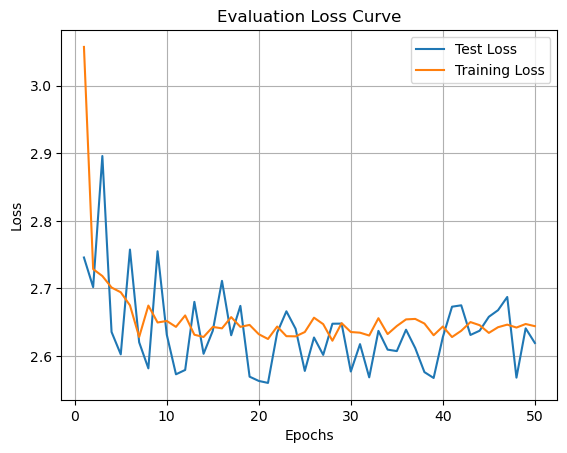

Mean Squared Error (MSE): 2.6170589923858643
R-squared: 0.25237001831466166
Epoch [1/50], Training Loss: 3.0502159694433213
Epoch [1/50], Test Loss: 2.8429126143455505
Epoch [2/50], Training Loss: 2.740348747730255
Epoch [2/50], Test Loss: 2.754560941696167
Epoch [3/50], Training Loss: 2.684661666870117
Epoch [3/50], Test Loss: 2.7427668347358702
Epoch [4/50], Training Loss: 2.671999248147011
Epoch [4/50], Test Loss: 2.9011393084526063
Epoch [5/50], Training Loss: 2.6825205572843553
Epoch [5/50], Test Loss: 2.725972096443176
Epoch [6/50], Training Loss: 2.6651183993816376
Epoch [6/50], Test Loss: 2.700564895153046
Epoch [7/50], Training Loss: 2.6645104451179504
Epoch [7/50], Test Loss: 2.6934519968032835
Epoch [8/50], Training Loss: 2.6644100904464723
Epoch [8/50], Test Loss: 2.771115764141083
Epoch [9/50], Training Loss: 2.6598757153749464
Epoch [9/50], Test Loss: 2.7111004872322084
Epoch [10/50], Training Loss: 2.657116785764694
Epoch [10/50], Test Loss: 2.7336302103996277
Epoch [11/

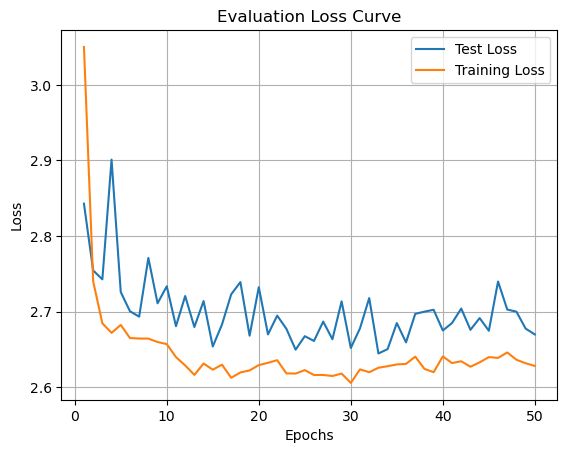

Mean Squared Error (MSE): 2.664456605911255
R-squared: 0.2610118094491491
Epoch [1/50], Training Loss: 2.864919588279724
Epoch [1/50], Test Loss: 2.925464166239047
Epoch [2/50], Training Loss: 2.671388883972168
Epoch [2/50], Test Loss: 3.155436504382295
Epoch [3/50], Training Loss: 2.6419674216270446
Epoch [3/50], Test Loss: 2.8051512466071133
Epoch [4/50], Training Loss: 2.6183477961540222
Epoch [4/50], Test Loss: 2.8152765667857453
Epoch [5/50], Training Loss: 2.6046576755523683
Epoch [5/50], Test Loss: 2.7584078963191363
Epoch [6/50], Training Loss: 2.594225706577301
Epoch [6/50], Test Loss: 2.7704325990555003
Epoch [7/50], Training Loss: 2.592178726863861
Epoch [7/50], Test Loss: 2.7843816352728457
Epoch [8/50], Training Loss: 2.598357861709595
Epoch [8/50], Test Loss: 2.821414608544054
Epoch [9/50], Training Loss: 2.6010129963874817
Epoch [9/50], Test Loss: 2.8527893917248273
Epoch [10/50], Training Loss: 2.589538875102997
Epoch [10/50], Test Loss: 2.90496739145285
Epoch [11/50], 

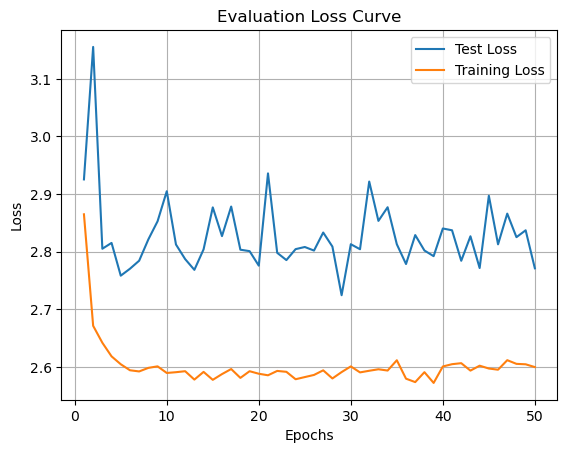

Mean Squared Error (MSE): 2.795907974243164
R-squared: 0.27198957343382857


In [14]:
env_names = ['CartPole-v1', 'MountainCarContinuous-v0', 'MountainCar-v0', 'Pendulum-v1']
num_samples_list = ['10k', '20k', '30k', '40k', '50k']

for env_name in env_names:

    env = gym.make(env_name)
    batch_size = 32


    for num_samples in num_samples_list:
        # Load datasets
        with open(env_name + '_' + num_samples + '_train_dataset.pkl', 'rb') as f:
            train_dataset_loaded = pickle.load(f)

        with open(env_name + '_' + num_samples + '_test_dataset.pkl', 'rb') as f:
            test_dataset_loaded = pickle.load(f)
            
        
        train_loader = torch.utils.data.DataLoader(train_dataset_loaded, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset_loaded, batch_size=batch_size, shuffle=False)
        
        #Initialize parameters for model
        action = env.action_space.sample()

        if isinstance(action, int):
            input_size = env.observation_space.shape[0] + 1
        elif isinstance(action, np.ndarray):
            input_size = env.observation_space.shape[0] + len(action)

        output_size = env.observation_space.shape[0] + 2
        num_hidden_layers = 3
        hidden_layer_nodes = 20
        activation = F.relu
        learning_rate = 0.01
        dropout_prob = 0.3
        num_networks = 5


        # Instantiate the model
        model = MC_Dropout_Net(input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation, dropout_prob, num_networks).to(device)

        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Training loop with evaluation
        num_epochs = 50
        train_losses = []
        test_losses = []
        save_interval = 100
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            epoch_train_loss = running_loss / len(train_loader)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_train_loss}")
            train_losses.append(epoch_train_loss)

            # Evaluation on test data
            #model.eval()
            running_test_loss = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    test_loss = criterion(outputs, labels)
                    running_test_loss += test_loss.item()
            epoch_test_loss = running_test_loss / len(test_loader)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {epoch_test_loss}")

            if (epoch + 1) % save_interval == 0:
                # Save model state
                torch.save(model.state_dict(), f'montecarlodropout_{env_name}_{num_samples}_epoch_{epoch+1}.pt')

            test_losses.append(epoch_test_loss)
            
        # Plotting the evaluation loss curve
        plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
        plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Evaluation Loss Curve')
        plt.legend()
        plt.grid(True)
        # Save the plot
        plt.savefig('montecarlodropout_'+ env_name + '_' + num_samples + '_evaluation_loss_curve.png')
        plt.show()


        # Lists to store predictions and true labels
        predictions = []
        true_labels = []

        # Iterate over test data
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predictions.extend(outputs.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        # Convert lists to numpy arrays
        predictions = np.array(predictions)
        true_labels = np.array(true_labels)

        # Calculate Mean Squared Error (MSE) and R-squared
        mse = mean_squared_error(true_labels, predictions)
        r2 = r2_score(true_labels, predictions)

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"R-squared: {r2}")

        model_weights_file_path = 'montecarlodropout_'+ env_name + '_' + num_samples +'.pth' 
        # Save the trained model
        torch.save(model.state_dict(), model_weights_file_path)

# Bayesian models for all samples

In [15]:
import gym
!pip install torchbnn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchbnn as bnn

import sklearn
from sklearn.metrics import mean_squared_error, r2_score

import pickle

import os

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [16]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
class BayesianNN(nn.Module):
    def __init__(self, input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation):
        super(BayesianNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_nodes = hidden_layer_nodes
        self.activation = activation
        
        # Define the layers
#         self.input_layer = nn.Linear(input_size, hidden_layer_nodes)
        self.input_layer = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=input_size, out_features=hidden_layer_nodes)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
#           self.hidden_layers.append(nn.Linear(hidden_layer_nodes, hidden_layer_nodes))
            self.hidden_layers.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=hidden_layer_nodes, out_features=hidden_layer_nodes))
#        self.output_layer = nn.Linear(hidden_layer_nodes, output_size)
        self.output_layer = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=hidden_layer_nodes, out_features=output_size)
        

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        output = self.output_layer(x)
        return output


Epoch [1/50], Training Loss: 0.8230289301549296
Epoch [1/50], Test Loss: 0.8055399741445269
Epoch [2/50], Training Loss: 0.7864284752849564
Epoch [2/50], Test Loss: 0.8119189455395653
Epoch [3/50], Training Loss: 0.7789552157143672
Epoch [3/50], Test Loss: 0.7922377084928846
Epoch [4/50], Training Loss: 0.7741717316239953
Epoch [4/50], Test Loss: 0.7883342249052865
Epoch [5/50], Training Loss: 0.7718970599877407
Epoch [5/50], Test Loss: 0.7871069927064199
Epoch [6/50], Training Loss: 0.7722492628838437
Epoch [6/50], Test Loss: 0.7880603056105356
Epoch [7/50], Training Loss: 0.7694936845882006
Epoch [7/50], Test Loss: 0.7900275692107186
Epoch [8/50], Training Loss: 0.7693205744146826
Epoch [8/50], Test Loss: 0.7939783883473229
Epoch [9/50], Training Loss: 0.7697520574250544
Epoch [9/50], Test Loss: 0.7841224045980544
Epoch [10/50], Training Loss: 0.7690144950650127
Epoch [10/50], Test Loss: 0.7819412776402065
Epoch [11/50], Training Loss: 0.7685261064791584
Epoch [11/50], Test Loss: 0.7

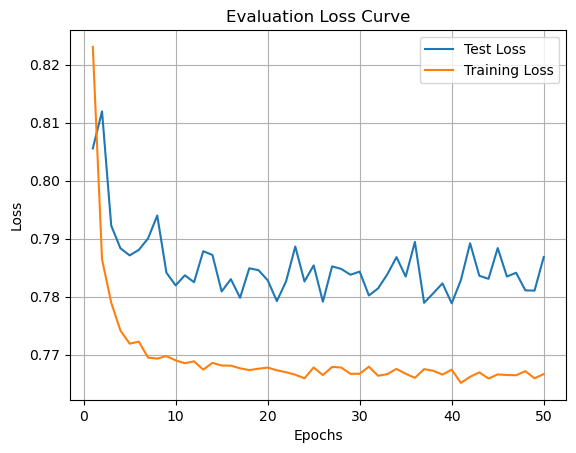

Mean Squared Error (MSE): 0.77973872423172
R-squared: 0.06365251420064189
bayesian_CartPole-v1_10k.pth
Epoch [1/50], Training Loss: 0.8034990706486617
Epoch [1/50], Test Loss: 0.7799243406643943
Epoch [2/50], Training Loss: 0.7770802824202174
Epoch [2/50], Test Loss: 0.772853599181251
Epoch [3/50], Training Loss: 0.7729347717024371
Epoch [3/50], Test Loss: 0.7693494217736381
Epoch [4/50], Training Loss: 0.7713137031077387
Epoch [4/50], Test Loss: 0.7634215690786876
Epoch [5/50], Training Loss: 0.7695157909821607
Epoch [5/50], Test Loss: 0.7674952423761762
Epoch [6/50], Training Loss: 0.7692494338857914
Epoch [6/50], Test Loss: 0.7728962032567888
Epoch [7/50], Training Loss: 0.7698009657764625
Epoch [7/50], Test Loss: 0.7692185261892894
Epoch [8/50], Training Loss: 0.7685195104090753
Epoch [8/50], Test Loss: 0.7663744139292884
Epoch [9/50], Training Loss: 0.7680131243374533
Epoch [9/50], Test Loss: 0.7660870911583068
Epoch [10/50], Training Loss: 0.768116667123136
Epoch [10/50], Test Lo

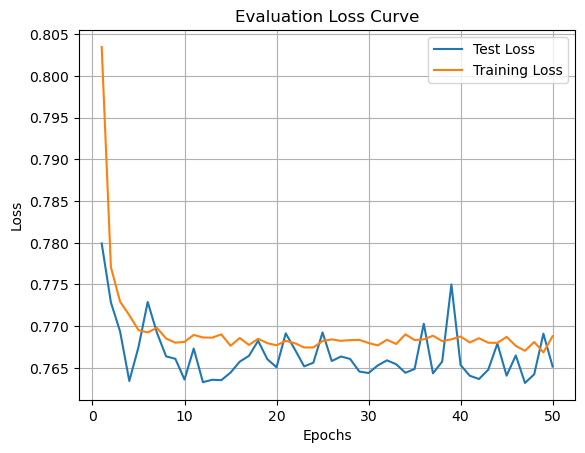

Mean Squared Error (MSE): 0.7587430477142334
R-squared: 0.05755586207707484
bayesian_CartPole-v1_20k.pth
Epoch [1/50], Training Loss: 0.8122222390219311
Epoch [1/50], Test Loss: 0.7753283739724057
Epoch [2/50], Training Loss: 0.7801881088080324
Epoch [2/50], Test Loss: 0.7706058868702422
Epoch [3/50], Training Loss: 0.7768613025446865
Epoch [3/50], Test Loss: 0.7715800845242561
Epoch [4/50], Training Loss: 0.775651235793148
Epoch [4/50], Test Loss: 0.7687159989108431
Epoch [5/50], Training Loss: 0.7741312570324275
Epoch [5/50], Test Loss: 0.7655396788044179
Epoch [6/50], Training Loss: 0.7735026504958518
Epoch [6/50], Test Loss: 0.7648972054111197
Epoch [7/50], Training Loss: 0.7732822877986136
Epoch [7/50], Test Loss: 0.7662547208527302
Epoch [8/50], Training Loss: 0.7733566966180636
Epoch [8/50], Test Loss: 0.7636438211862077
Epoch [9/50], Training Loss: 0.7730254885677332
Epoch [9/50], Test Loss: 0.7659655390901768
Epoch [10/50], Training Loss: 0.7722237605785085
Epoch [10/50], Test

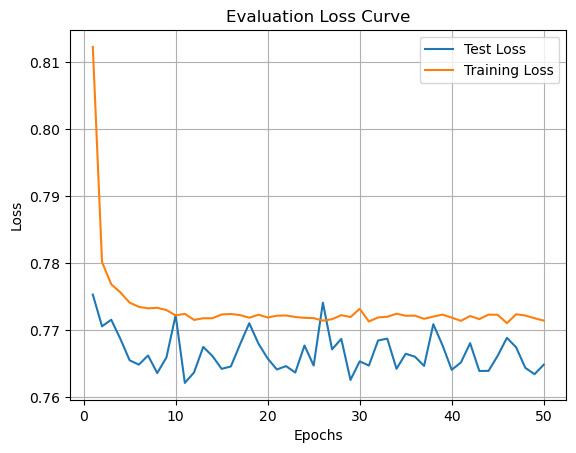

Mean Squared Error (MSE): 0.7584519982337952
R-squared: 0.05484418616124467
bayesian_CartPole-v1_30k.pth
Epoch [1/50], Training Loss: 0.8005402664561848
Epoch [1/50], Test Loss: 0.7694759257286193
Epoch [2/50], Training Loss: 0.7776320330151073
Epoch [2/50], Test Loss: 0.7695654131976731
Epoch [3/50], Training Loss: 0.7750584115753403
Epoch [3/50], Test Loss: 0.7656051497535402
Epoch [4/50], Training Loss: 0.7732139385187186
Epoch [4/50], Test Loss: 0.7680995832401443
Epoch [5/50], Training Loss: 0.7732560481582131
Epoch [5/50], Test Loss: 0.7640999408357172
Epoch [6/50], Training Loss: 0.7730034355457489
Epoch [6/50], Test Loss: 0.7628339901863341
Epoch [7/50], Training Loss: 0.7726750848117051
Epoch [7/50], Test Loss: 0.7684414579098918
Epoch [8/50], Training Loss: 0.7723038872996053
Epoch [8/50], Test Loss: 0.7688747383208864
Epoch [9/50], Training Loss: 0.7719457555603195
Epoch [9/50], Test Loss: 0.7619881777174444
Epoch [10/50], Training Loss: 0.7724947844232831
Epoch [10/50], Tes

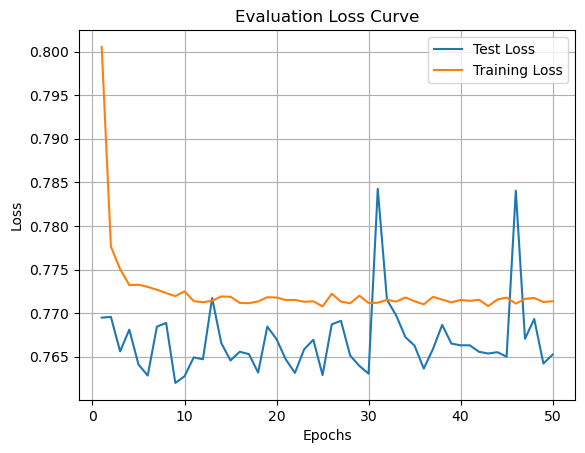

Mean Squared Error (MSE): 0.7579168677330017
R-squared: 0.050569306947756965
bayesian_CartPole-v1_40k.pth
Epoch [1/50], Training Loss: 0.7945127502429209
Epoch [1/50], Test Loss: 0.7879130443254598
Epoch [2/50], Training Loss: 0.7727378742109767
Epoch [2/50], Test Loss: 0.7748677953363607
Epoch [3/50], Training Loss: 0.7713733214459164
Epoch [3/50], Test Loss: 0.7784388443342032
Epoch [4/50], Training Loss: 0.770768665033374
Epoch [4/50], Test Loss: 0.7762155320507269
Epoch [5/50], Training Loss: 0.770527477863786
Epoch [5/50], Test Loss: 0.7830759728678499
Epoch [6/50], Training Loss: 0.7704739877217107
Epoch [6/50], Test Loss: 0.7765608084277985
Epoch [7/50], Training Loss: 0.7702698016719376
Epoch [7/50], Test Loss: 0.7760049742631638
Epoch [8/50], Training Loss: 0.7705769588430817
Epoch [8/50], Test Loss: 0.7751803641882948
Epoch [9/50], Training Loss: 0.7701514742309622
Epoch [9/50], Test Loss: 0.7765137790300595
Epoch [10/50], Training Loss: 0.7704376216700894
Epoch [10/50], Test

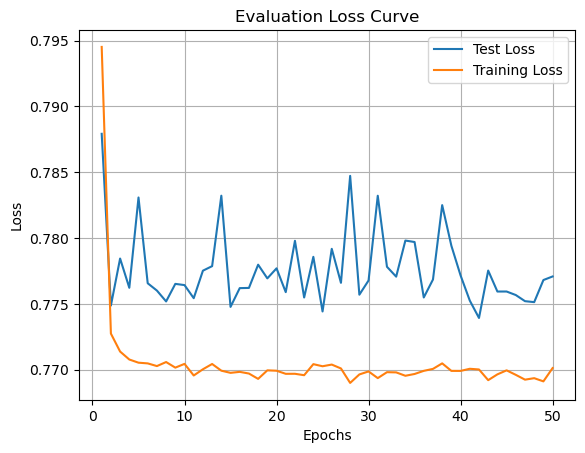

Mean Squared Error (MSE): 0.7701632976531982
R-squared: 0.053961311121784206
bayesian_CartPole-v1_50k.pth
Epoch [1/50], Training Loss: 0.5066285647153854
Epoch [1/50], Test Loss: 0.5145050769760495
Epoch [2/50], Training Loss: 0.49770898938179015
Epoch [2/50], Test Loss: 0.5133011492471846
Epoch [3/50], Training Loss: 0.49583824777603147
Epoch [3/50], Test Loss: 0.5117626426711915
Epoch [4/50], Training Loss: 0.4960703421831131
Epoch [4/50], Test Loss: 0.5110208089389499
Epoch [5/50], Training Loss: 0.4956093137264252
Epoch [5/50], Test Loss: 0.5129056492495159
Epoch [6/50], Training Loss: 0.4954906321763992
Epoch [6/50], Test Loss: 0.5108264197432806
Epoch [7/50], Training Loss: 0.495625342130661
Epoch [7/50], Test Loss: 0.5113973958151681
Epoch [8/50], Training Loss: 0.49533479714393613
Epoch [8/50], Test Loss: 0.5128299716919188
Epoch [9/50], Training Loss: 0.49551855647563936
Epoch [9/50], Test Loss: 0.511679142240494
Epoch [10/50], Training Loss: 0.49552817571163177
Epoch [10/50],

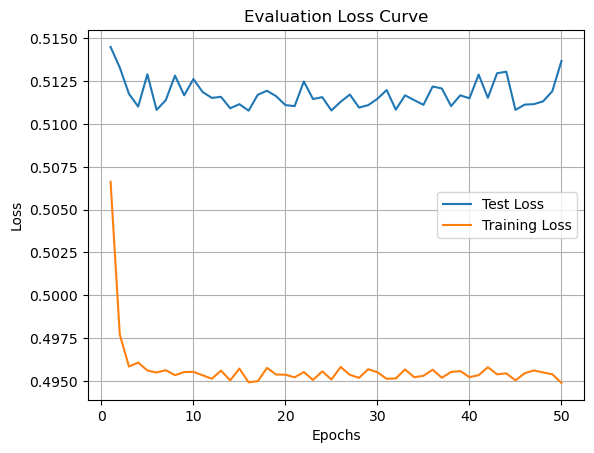

Mean Squared Error (MSE): 0.513388454914093
R-squared: -0.025823774027863178
bayesian_MountainCarContinuous-v0_10k.pth
Epoch [1/50], Training Loss: 0.5164753974974156
Epoch [1/50], Test Loss: 0.4960710599422455
Epoch [2/50], Training Loss: 0.5090536094307899
Epoch [2/50], Test Loss: 0.4956945786476135
Epoch [3/50], Training Loss: 0.50857700163126
Epoch [3/50], Test Loss: 0.4956772840023041
Epoch [4/50], Training Loss: 0.5082721790075302
Epoch [4/50], Test Loss: 0.49525618720054626
Epoch [5/50], Training Loss: 0.5084268374443054
Epoch [5/50], Test Loss: 0.495509546995163
Epoch [6/50], Training Loss: 0.508281710922718
Epoch [6/50], Test Loss: 0.4958146693706512
Epoch [7/50], Training Loss: 0.5079450873732567
Epoch [7/50], Test Loss: 0.49558526730537417
Epoch [8/50], Training Loss: 0.5082718296051025
Epoch [8/50], Test Loss: 0.4947368607521057
Epoch [9/50], Training Loss: 0.5086105499863625
Epoch [9/50], Test Loss: 0.49481352472305296
Epoch [10/50], Training Loss: 0.5081456862688064
Epoch

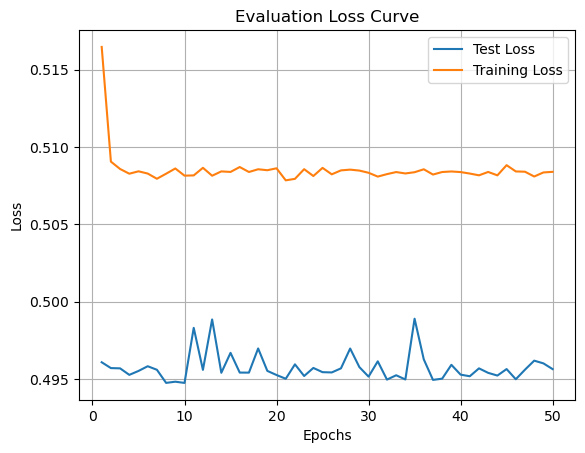

Mean Squared Error (MSE): 0.4948810935020447
R-squared: -0.009771794236895115
bayesian_MountainCarContinuous-v0_20k.pth
Epoch [1/50], Training Loss: 0.5108863350550333
Epoch [1/50], Test Loss: 0.5147184028904489
Epoch [2/50], Training Loss: 0.5050108635425568
Epoch [2/50], Test Loss: 0.5144308937039781
Epoch [3/50], Training Loss: 0.5045513425469399
Epoch [3/50], Test Loss: 0.5152122028013493
Epoch [4/50], Training Loss: 0.5044804173707962
Epoch [4/50], Test Loss: 0.5143100208741553
Epoch [5/50], Training Loss: 0.5047150527238846
Epoch [5/50], Test Loss: 0.5146331898075469
Epoch [6/50], Training Loss: 0.5046789546410243
Epoch [6/50], Test Loss: 0.5146060297463803
Epoch [7/50], Training Loss: 0.5047061379551887
Epoch [7/50], Test Loss: 0.514381911050766
Epoch [8/50], Training Loss: 0.5046385170618694
Epoch [8/50], Test Loss: 0.5152610180542824
Epoch [9/50], Training Loss: 0.5045314970413843
Epoch [9/50], Test Loss: 0.5161844325509477
Epoch [10/50], Training Loss: 0.5046004974444708
Epoc

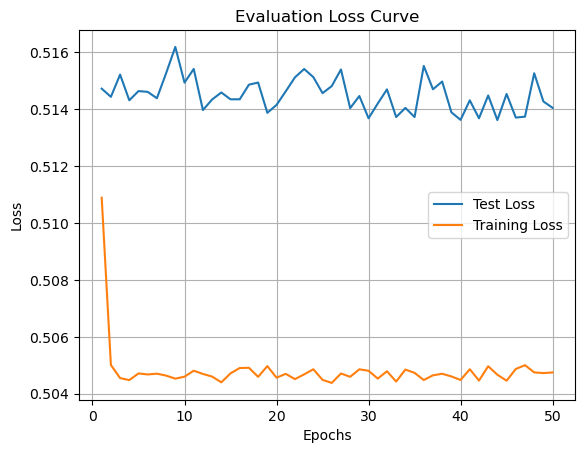

Mean Squared Error (MSE): 0.5126556754112244
R-squared: -0.04796936901739007
bayesian_MountainCarContinuous-v0_30k.pth
Epoch [1/50], Training Loss: 0.5110619724690915
Epoch [1/50], Test Loss: 0.5102225624322891
Epoch [2/50], Training Loss: 0.5041876958012581
Epoch [2/50], Test Loss: 0.5102781730890275
Epoch [3/50], Training Loss: 0.5039718462228775
Epoch [3/50], Test Loss: 0.5100509443283081
Epoch [4/50], Training Loss: 0.5042183962464333
Epoch [4/50], Test Loss: 0.5107752387523651
Epoch [5/50], Training Loss: 0.5040965511053801
Epoch [5/50], Test Loss: 0.5098372757434845
Epoch [6/50], Training Loss: 0.5042409373521805
Epoch [6/50], Test Loss: 0.5098643780946731
Epoch [7/50], Training Loss: 0.5039761265516282
Epoch [7/50], Test Loss: 0.510653037905693
Epoch [8/50], Training Loss: 0.5041767607033253
Epoch [8/50], Test Loss: 0.5098451778888703
Epoch [9/50], Training Loss: 0.5041904560625553
Epoch [9/50], Test Loss: 0.51110655605793
Epoch [10/50], Training Loss: 0.5042167048454285
Epoch [

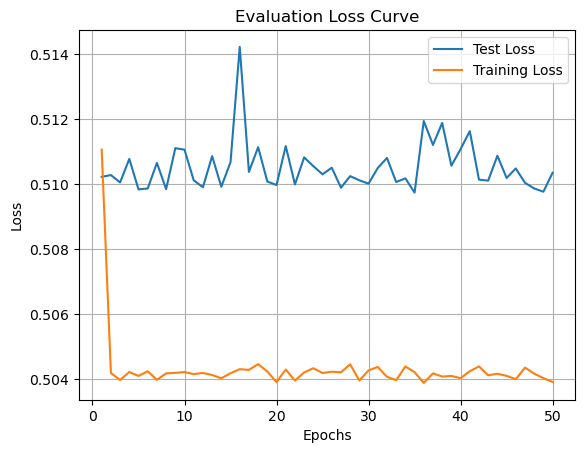

Mean Squared Error (MSE): 0.5097788572311401
R-squared: -0.007876163312994289
bayesian_MountainCarContinuous-v0_40k.pth
Epoch [1/50], Training Loss: 0.5053681950330734
Epoch [1/50], Test Loss: 0.5011913393633053
Epoch [2/50], Training Loss: 0.5023755512952804
Epoch [2/50], Test Loss: 0.5009502667588548
Epoch [3/50], Training Loss: 0.5022968901157379
Epoch [3/50], Test Loss: 0.5010176083912103
Epoch [4/50], Training Loss: 0.5024110539913178
Epoch [4/50], Test Loss: 0.501586204519668
Epoch [5/50], Training Loss: 0.5024154505252838
Epoch [5/50], Test Loss: 0.5031266400037101
Epoch [6/50], Training Loss: 0.5022092640280723
Epoch [6/50], Test Loss: 0.502788194547446
Epoch [7/50], Training Loss: 0.5022419678449631
Epoch [7/50], Test Loss: 0.5020225540327188
Epoch [8/50], Training Loss: 0.5023972910046578
Epoch [8/50], Test Loss: 0.5019219995687564
Epoch [9/50], Training Loss: 0.5024715682029725
Epoch [9/50], Test Loss: 0.5010579930136378
Epoch [10/50], Training Loss: 0.5023291047334671
Epoch

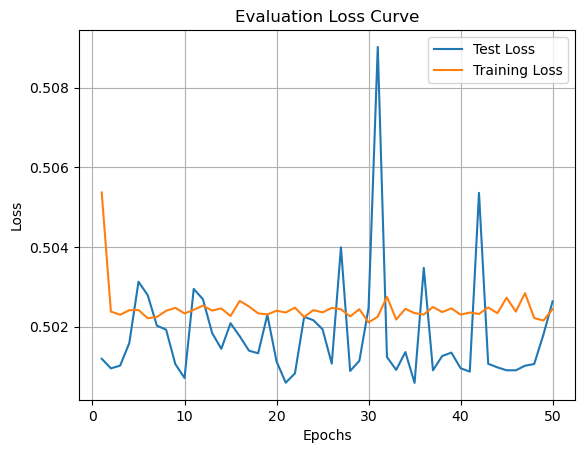

Mean Squared Error (MSE): 0.5013044476509094
R-squared: -0.060377843900838835
bayesian_MountainCarContinuous-v0_50k.pth
Epoch [1/50], Training Loss: 0.5512191573381424
Epoch [1/50], Test Loss: 0.5284343144250294
Epoch [2/50], Training Loss: 0.5206876354217529
Epoch [2/50], Test Loss: 0.5190723084268116
Epoch [3/50], Training Loss: 0.5145377379655838
Epoch [3/50], Test Loss: 0.5170461540184323
Epoch [4/50], Training Loss: 0.5127451920509338
Epoch [4/50], Test Loss: 0.515056093060781
Epoch [5/50], Training Loss: 0.5122161912918091
Epoch [5/50], Test Loss: 0.5133915794274163
Epoch [6/50], Training Loss: 0.5110046416521072
Epoch [6/50], Test Loss: 0.5131323820068723
Epoch [7/50], Training Loss: 0.510584517121315
Epoch [7/50], Test Loss: 0.513430236823975
Epoch [8/50], Training Loss: 0.5101554958820343
Epoch [8/50], Test Loss: 0.5121053466721187
Epoch [9/50], Training Loss: 0.5095936976671219
Epoch [9/50], Test Loss: 0.5121786504510849
Epoch [10/50], Training Loss: 0.5099310970306397
Epoch 

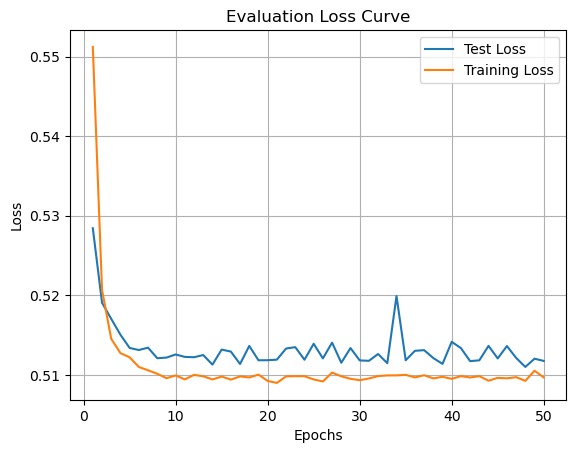

Mean Squared Error (MSE): 0.5104039907455444
R-squared: -0.00045110841960749326
bayesian_MountainCar-v0_10k.pth
Epoch [1/50], Training Loss: 0.5246624042987823
Epoch [1/50], Test Loss: 0.49392630624771117
Epoch [2/50], Training Loss: 0.5105240806937218
Epoch [2/50], Test Loss: 0.4896912190914154
Epoch [3/50], Training Loss: 0.5084180366992951
Epoch [3/50], Test Loss: 0.48845097827911377
Epoch [4/50], Training Loss: 0.508213148355484
Epoch [4/50], Test Loss: 0.48850353074073793
Epoch [5/50], Training Loss: 0.5081505818367005
Epoch [5/50], Test Loss: 0.4886703300476074
Epoch [6/50], Training Loss: 0.5082424409985542
Epoch [6/50], Test Loss: 0.48836538577079774
Epoch [7/50], Training Loss: 0.5081097288727761
Epoch [7/50], Test Loss: 0.4908377091884613
Epoch [8/50], Training Loss: 0.5085439068675042
Epoch [8/50], Test Loss: 0.48923517179489134
Epoch [9/50], Training Loss: 0.5086311207413673
Epoch [9/50], Test Loss: 0.4882089593410492
Epoch [10/50], Training Loss: 0.5082865741848945
Epoch [

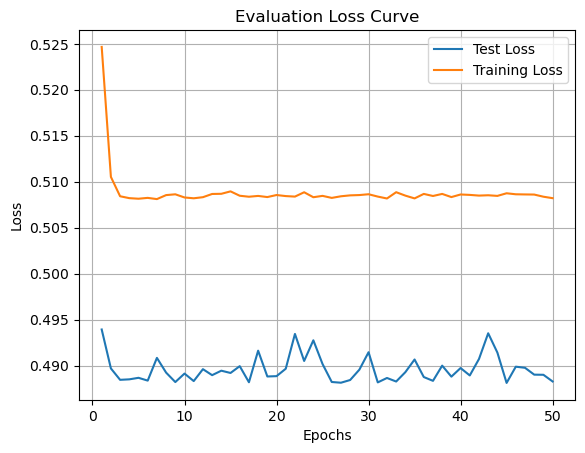

Mean Squared Error (MSE): 0.48735541105270386
R-squared: -0.00023141696071249385
bayesian_MountainCar-v0_20k.pth
Epoch [1/50], Training Loss: 0.525602009733518
Epoch [1/50], Test Loss: 0.4905708313305327
Epoch [2/50], Training Loss: 0.5096824225982031
Epoch [2/50], Test Loss: 0.48903590757796106
Epoch [3/50], Training Loss: 0.5082326282660167
Epoch [3/50], Test Loss: 0.4885902747194818
Epoch [4/50], Training Loss: 0.507813785592715
Epoch [4/50], Test Loss: 0.48842773015828844
Epoch [5/50], Training Loss: 0.5081159301201502
Epoch [5/50], Test Loss: 0.4890848209566258
Epoch [6/50], Training Loss: 0.5078263643980027
Epoch [6/50], Test Loss: 0.48955028155382646
Epoch [7/50], Training Loss: 0.5083685823281606
Epoch [7/50], Test Loss: 0.48877247280262887
Epoch [8/50], Training Loss: 0.5080064441760381
Epoch [8/50], Test Loss: 0.4876353661430643
Epoch [9/50], Training Loss: 0.5079331654707591
Epoch [9/50], Test Loss: 0.4923434373229108
Epoch [10/50], Training Loss: 0.5084112943410873
Epoch [1

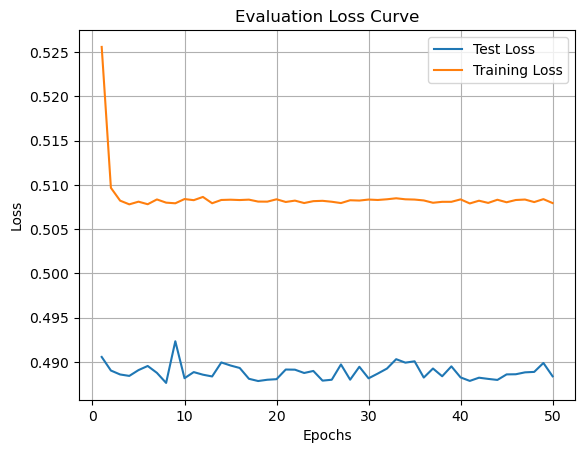

Mean Squared Error (MSE): 0.487374871969223
R-squared: -0.0009130420124227046
bayesian_MountainCar-v0_30k.pth
Epoch [1/50], Training Loss: 0.5190241350233555
Epoch [1/50], Test Loss: 0.5116693577766418
Epoch [2/50], Training Loss: 0.5058956795334816
Epoch [2/50], Test Loss: 0.507344529747963
Epoch [3/50], Training Loss: 0.5050610464215278
Epoch [3/50], Test Loss: 0.5066607041358948
Epoch [4/50], Training Loss: 0.5046280387341976
Epoch [4/50], Test Loss: 0.5073678015470505
Epoch [5/50], Training Loss: 0.5049507583528757
Epoch [5/50], Test Loss: 0.5071268978118897
Epoch [6/50], Training Loss: 0.5051176523715257
Epoch [6/50], Test Loss: 0.5106709605455398
Epoch [7/50], Training Loss: 0.5049743126928806
Epoch [7/50], Test Loss: 0.5078618042469024
Epoch [8/50], Training Loss: 0.5052010794281959
Epoch [8/50], Test Loss: 0.5071072043180466
Epoch [9/50], Training Loss: 0.5049143983721733
Epoch [9/50], Test Loss: 0.5074407801628112
Epoch [10/50], Training Loss: 0.5051003178954124
Epoch [10/50],

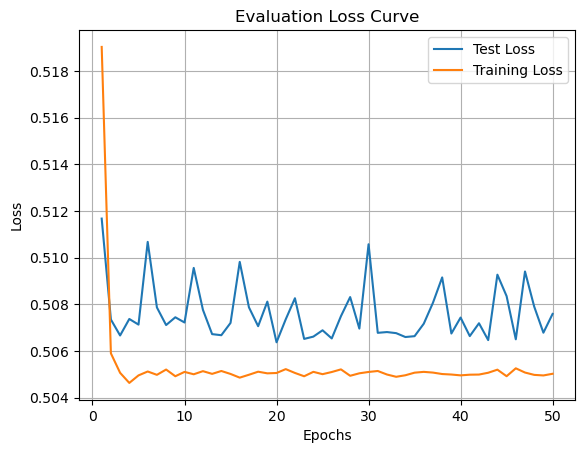

Mean Squared Error (MSE): 0.5064736604690552
R-squared: -0.0009392974724930503
bayesian_MountainCar-v0_40k.pth
Epoch [1/50], Training Loss: 0.5108330244541168
Epoch [1/50], Test Loss: 0.5021367283484426
Epoch [2/50], Training Loss: 0.5001474438905716
Epoch [2/50], Test Loss: 0.5002370217737679
Epoch [3/50], Training Loss: 0.49984814758300783
Epoch [3/50], Test Loss: 0.49934738731612793
Epoch [4/50], Training Loss: 0.4995392032265663
Epoch [4/50], Test Loss: 0.499744255226641
Epoch [5/50], Training Loss: 0.4999098552942276
Epoch [5/50], Test Loss: 0.49984316056528794
Epoch [6/50], Training Loss: 0.4998450465798378
Epoch [6/50], Test Loss: 0.49899920883079685
Epoch [7/50], Training Loss: 0.4998030350446701
Epoch [7/50], Test Loss: 0.499459102702217
Epoch [8/50], Training Loss: 0.49982520570755007
Epoch [8/50], Test Loss: 0.49960112914490623
Epoch [9/50], Training Loss: 0.5000672290921211
Epoch [9/50], Test Loss: 0.502477414691791
Epoch [10/50], Training Loss: 0.4999123033285141
Epoch [10

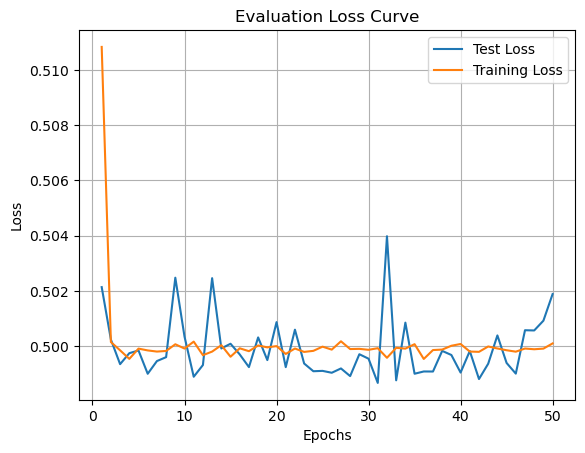

Mean Squared Error (MSE): 0.49856531620025635
R-squared: -0.0007984218073647797
bayesian_MountainCar-v0_50k.pth
Epoch [1/50], Training Loss: 4.201851711273194
Epoch [1/50], Test Loss: 3.9187315267229836
Epoch [2/50], Training Loss: 3.0508893637657164
Epoch [2/50], Test Loss: 3.627733998828464
Epoch [3/50], Training Loss: 2.8290878429412842
Epoch [3/50], Test Loss: 3.10408293822455
Epoch [4/50], Training Loss: 2.7752066798210144
Epoch [4/50], Test Loss: 3.3295576837327747
Epoch [5/50], Training Loss: 2.633891188144684
Epoch [5/50], Test Loss: 3.1971073093868436
Epoch [6/50], Training Loss: 2.576364104747772
Epoch [6/50], Test Loss: 3.2587050256274996
Epoch [7/50], Training Loss: 2.590359311103821
Epoch [7/50], Test Loss: 3.0082211286302596
Epoch [8/50], Training Loss: 2.54716801404953
Epoch [8/50], Test Loss: 3.1726167012774753
Epoch [9/50], Training Loss: 2.5488808612823486
Epoch [9/50], Test Loss: 3.131338424152798
Epoch [10/50], Training Loss: 2.514574333190918
Epoch [10/50], Test Lo

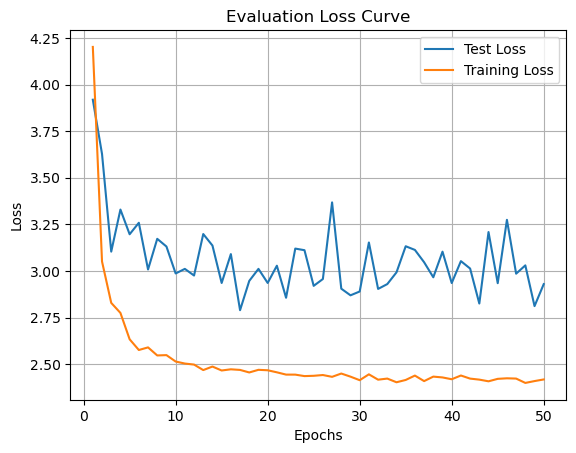

Mean Squared Error (MSE): 2.9127511978149414
R-squared: 0.21202250322906152
bayesian_Pendulum-v1_10k.pth
Epoch [1/50], Training Loss: 3.511584943294525
Epoch [1/50], Test Loss: 2.8945251569747925
Epoch [2/50], Training Loss: 2.736366269826889
Epoch [2/50], Test Loss: 2.748532938957214
Epoch [3/50], Training Loss: 2.623587126493454
Epoch [3/50], Test Loss: 2.6103293151855467
Epoch [4/50], Training Loss: 2.559560656785965
Epoch [4/50], Test Loss: 2.5353804864883425
Epoch [5/50], Training Loss: 2.515228482246399
Epoch [5/50], Test Loss: 2.5842866706848144
Epoch [6/50], Training Loss: 2.4916772420406343
Epoch [6/50], Test Loss: 2.553053875923157
Epoch [7/50], Training Loss: 2.481615828037262
Epoch [7/50], Test Loss: 2.52232532119751
Epoch [8/50], Training Loss: 2.477313635110855
Epoch [8/50], Test Loss: 2.5504841146469115
Epoch [9/50], Training Loss: 2.4631839299201967
Epoch [9/50], Test Loss: 2.4924926195144654
Epoch [10/50], Training Loss: 2.470905108451843
Epoch [10/50], Test Loss: 2.61

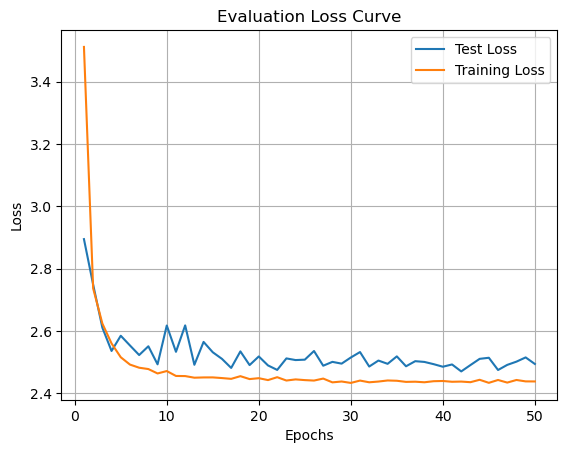

Mean Squared Error (MSE): 2.4662423133850098
R-squared: 0.27397063183868225
bayesian_Pendulum-v1_20k.pth
Epoch [1/50], Training Loss: 3.3400256746610006
Epoch [1/50], Test Loss: 2.647628862807091
Epoch [2/50], Training Loss: 2.677828341325124
Epoch [2/50], Test Loss: 2.590886203532523
Epoch [3/50], Training Loss: 2.5801536043485007
Epoch [3/50], Test Loss: 2.495530602145702
Epoch [4/50], Training Loss: 2.5435309931437176
Epoch [4/50], Test Loss: 2.4935365496797766
Epoch [5/50], Training Loss: 2.516166260719299
Epoch [5/50], Test Loss: 2.4542021732381047
Epoch [6/50], Training Loss: 2.5021704896291097
Epoch [6/50], Test Loss: 2.4296100589823215
Epoch [7/50], Training Loss: 2.488606932957967
Epoch [7/50], Test Loss: 2.4622235209383865
Epoch [8/50], Training Loss: 2.476278058052063
Epoch [8/50], Test Loss: 2.491675277339651
Epoch [9/50], Training Loss: 2.4821275955835977
Epoch [9/50], Test Loss: 2.4697243913691094
Epoch [10/50], Training Loss: 2.474730715751648
Epoch [10/50], Test Loss: 2

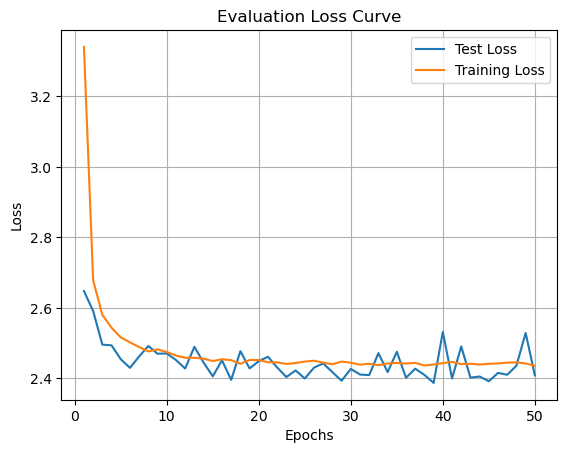

Mean Squared Error (MSE): 2.3819739818573
R-squared: 0.28929159148780037
bayesian_Pendulum-v1_30k.pth
Epoch [1/50], Training Loss: 3.0988512966632844
Epoch [1/50], Test Loss: 2.687442921638489
Epoch [2/50], Training Loss: 2.558513342618942
Epoch [2/50], Test Loss: 2.5697490406036376
Epoch [3/50], Training Loss: 2.4749048782587053
Epoch [3/50], Test Loss: 2.5488576560020446
Epoch [4/50], Training Loss: 2.459243669271469
Epoch [4/50], Test Loss: 2.508488750934601
Epoch [5/50], Training Loss: 2.4386494674682617
Epoch [5/50], Test Loss: 2.5222213444709776
Epoch [6/50], Training Loss: 2.4294122922420502
Epoch [6/50], Test Loss: 2.481556800365448
Epoch [7/50], Training Loss: 2.420610554099083
Epoch [7/50], Test Loss: 2.519391427516937
Epoch [8/50], Training Loss: 2.405794061779976
Epoch [8/50], Test Loss: 2.44179882478714
Epoch [9/50], Training Loss: 2.4113774806261064
Epoch [9/50], Test Loss: 2.44958283662796
Epoch [10/50], Training Loss: 2.4081805568933485
Epoch [10/50], Test Loss: 2.45182

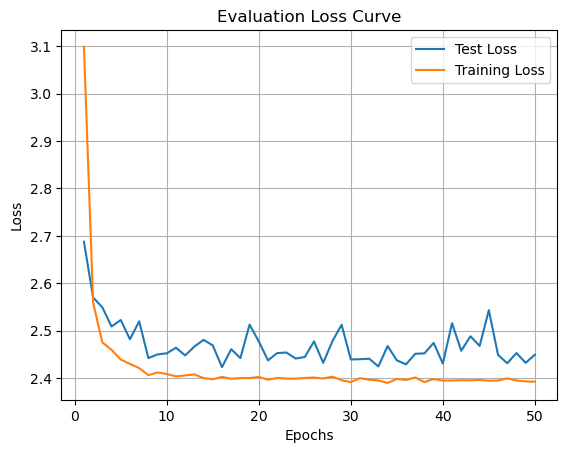

Mean Squared Error (MSE): 2.416429042816162
R-squared: 0.29673595151040477
bayesian_Pendulum-v1_40k.pth
Epoch [1/50], Training Loss: 3.0068145561218262
Epoch [1/50], Test Loss: 2.714286253094292
Epoch [2/50], Training Loss: 2.5268784240722657
Epoch [2/50], Test Loss: 2.6999351220389904
Epoch [3/50], Training Loss: 2.4709726029396055
Epoch [3/50], Test Loss: 2.639690197313936
Epoch [4/50], Training Loss: 2.4423865710258483
Epoch [4/50], Test Loss: 2.5705886450819313
Epoch [5/50], Training Loss: 2.4360550607681275
Epoch [5/50], Test Loss: 2.61960814440974
Epoch [6/50], Training Loss: 2.42586521692276
Epoch [6/50], Test Loss: 2.6015139620144145
Epoch [7/50], Training Loss: 2.431244017791748
Epoch [7/50], Test Loss: 2.7783433256057886
Epoch [8/50], Training Loss: 2.4294132665634156
Epoch [8/50], Test Loss: 2.5772452815272175
Epoch [9/50], Training Loss: 2.424723997116089
Epoch [9/50], Test Loss: 2.5507508581057907
Epoch [10/50], Training Loss: 2.422249877548218
Epoch [10/50], Test Loss: 2.

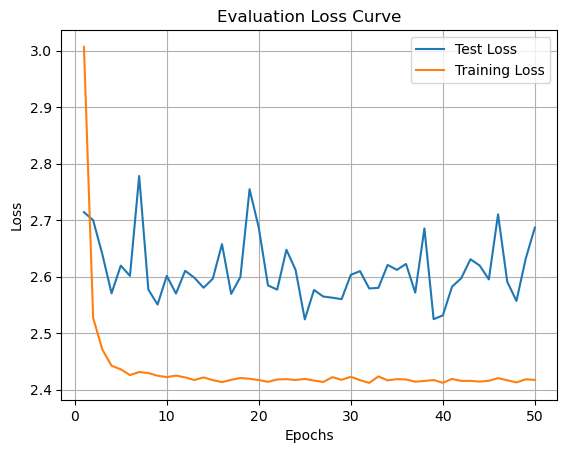

Mean Squared Error (MSE): 2.657709836959839
R-squared: 0.2842193020622025
bayesian_Pendulum-v1_50k.pth


In [18]:
env_names = ['CartPole-v1', 'MountainCarContinuous-v0', 'MountainCar-v0', 'Pendulum-v1']
num_samples_list = ['10k', '20k', '30k', '40k', '50k']

for env_name in env_names:

    env = gym.make(env_name)
    batch_size = 32


    for num_samples in num_samples_list:
        # Load datasets
        with open(env_name + '_' + num_samples + '_train_dataset.pkl', 'rb') as f:
            train_dataset_loaded = pickle.load(f)

        with open(env_name + '_' + num_samples + '_test_dataset.pkl', 'rb') as f:
            test_dataset_loaded = pickle.load(f)

        train_loader = torch.utils.data.DataLoader(train_dataset_loaded, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset_loaded, batch_size=batch_size, shuffle=False)
        
        #Initialize parameters for model
        action = env.action_space.sample()

        if isinstance(action, int):
            input_size = env.observation_space.shape[0] + 1
        elif isinstance(action, np.ndarray):
            input_size = env.observation_space.shape[0] + len(action)

        output_size = env.observation_space.shape[0] + 2
        num_hidden_layers = 3
        hidden_layer_nodes = 20
        activation = F.relu
        learning_rate = 0.01
        dropout_prob = 0.3
        num_networks = 5

        # Instantiate the model
        model = BayesianNN(input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation).to(device)

        mse_loss = nn.MSELoss()
        kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
        kl_weight = 0.01

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Training loop with evaluation
        num_epochs = 50
        train_losses = []
        test_losses = []
        save_interval = 100
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = mse_loss(outputs, labels) + kl_weight * kl_loss(model)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            epoch_train_loss = running_loss / len(train_loader)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_train_loss}")
            train_losses.append(epoch_train_loss)

            # Evaluation on test data
            #model.eval()
            running_test_loss = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    test_loss = mse_loss(outputs, labels) + kl_weight * kl_loss(model)
                    running_test_loss += test_loss.item()
            epoch_test_loss = running_test_loss / len(test_loader)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {epoch_test_loss}")

            if (epoch + 1) % save_interval == 0:
                # Save model state
                torch.save(model.state_dict(), f'bayesian_{env_name}_{num_samples}_epoch_{epoch+1}.pt')

            test_losses.append(epoch_test_loss)
    
        # Plotting the evaluation loss curve
        plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
        plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Evaluation Loss Curve')
        plt.legend()
        plt.grid(True)
        # Save the plot
        plt.savefig('bayesian_'+ env_name + '_' + num_samples + '_evaluation_loss_curve.png')
        plt.show()
        
        # Switch model to evaluation mode
        #model.eval()

        # Lists to store predictions and true labels
        predictions = []
        true_labels = []

        # Iterate over test data
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predictions.extend(outputs.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        # Convert lists to numpy arrays
        predictions = np.array(predictions)
        true_labels = np.array(true_labels)

        # Calculate Mean Squared Error (MSE) and R-squared
        mse = mean_squared_error(true_labels, predictions)
        r2 = r2_score(true_labels, predictions)

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"R-squared: {r2}")
        
        model_weights_file_path = 'bayesian_'+ env_name + '_' + num_samples +'.pth' 
        print(model_weights_file_path)
        # Save the trained model
        torch.save(model.state_dict(), model_weights_file_path)